# **Stock Price Prediction: Time-Series Forecasting with PyTorch and LSTMs**

**Abstract:**
*This project presents a comprehensive analysis and predictive model for the stock prices of five leading technology corporations: NVIDIA (NVDA), Apple (AAPL), Microsoft (MSFT), Google (GOOGL), and Amazon (AMZN). Utilizing a 15-year historical dataset (2010-2024), this report begins with an in-depth Exploratory Data Analysis (EDA) to uncover trends, volatility patterns, and comparative growth trajectories. Following the EDA, a Long Short-Term Memory (LSTM) recurrent neural network is developed using the PyTorch framework. The model is trained to forecast future closing prices based on historical sequences. The report concludes with a quantitative evaluation of the model's performance using Root Mean Squared Error (RMSE) and a qualitative assessment through detailed, interactive visualizations, demonstrating the efficacy of deep learning in the complex domain of financial forecasting.*

---
## **1. Introduction and Project Setup**

### **1.1. The Challenge of Financial Forecasting**
Predicting stock market movements is a notoriously difficult task due to the market's inherent volatility and its sensitivity to a vast number of factors, from macroeconomic indicators to public sentiment. While no model can predict the future with perfect accuracy, modern machine learning techniques can identify complex, non-linear patterns in historical data that are often invisible to traditional statistical methods. This project aims to apply one such technique, a Long Short-Term Memory (LSTM) network, to this challenge.

### **1.2. Dataset and Environment**
* **Dataset:** The analysis is based on the `15Y Stock Data: NVDA, AAPL, MSFT, GOOGL & AMZN` dataset. It contains daily trading data, including Open, High, Low, Close, and Volume for each of the five stocks from January 2010 to early 2025.
* **Environment:** The entire project is developed in Google Colab, leveraging its cloud-based computational resources. The key libraries employed include:
    * **`pandas` & `numpy`:** For efficient data manipulation and numerical operations.
    * **`matplotlib` & `seaborn`:** For static Exploratory Data Analysis visualizations.
    * **`plotly`:** For creating interactive, publication-quality charts.
    * **`scikit-learn`:** For data preprocessing, specifically data scaling.
    * **`torch`:** The core deep learning framework used to build and train our LSTM model.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from google.colab import files
import io

# TensorFlow / Keras Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM as KerasLSTM

# PyTorch Imports
import torch
import torch.nn as nn

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

class PyTorchLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PyTorchLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

print("Please upload your '15Y_Stock_Data.csv' file.")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), parse_dates=['Date'])
df.set_index('Date', inplace=True)
print(f"\nSuccessfully loaded {file_name}!")

Please upload your '15Y_Stock_Data.csv' file.


Saving 15Y_Stock_Data.csv to 15Y_Stock_Data (2).csv

Successfully loaded 15Y_Stock_Data (2).csv!


---
## **2. Exploratory Data Analysis (EDA): Uncovering Market Behavior**
Before building a predictive model, it is crucial to thoroughly understand the data. EDA helps us visualize the historical behavior of each stock, identify key characteristics, and form hypotheses about their market dynamics.

### **2.1. Visualizing Trends with Moving Averages**
A moving average is a widely used technical indicator that helps smooth out price action by filtering out short-term noise. We plot the 100-day and 200-day Moving Averages (MA) to better identify the medium and long-term trends.
* **Interpretation:** When the daily price is consistently above its MAs, it signals a strong bullish (upward) trend. Conversely, when it trades below its MAs, it indicates a bearish (downward) trend. Crossovers between the price and its MAs are often interpreted by traders as potential buy or sell signals.

### **2.2. Analyzing Daily Trading Metrics**
By plotting the **Open, High, Low, Close, and Volume** on individual subplots, we gain a granular view of each stock's daily trading characteristics.
* **Price Range (High-Low):** A wider daily range suggests higher intraday volatility.
* **Volume:** Spikes in trading volume often coincide with significant price movements, earnings announcements, or major news events, indicating periods of high market interest and activity.

In [76]:
def generate_eda_plots(dataframe, ticker):
    """
    Generates a comprehensive set of EDA plots for a given stock ticker.
    """
    print(f"--- Generating EDA Plots for {ticker} ---")

    close_col = f'Close_{ticker}'
    volume_col = f'Volume_{ticker}'

    # Calculate Moving Averages
    ma_100 = dataframe[close_col].rolling(100).mean()
    ma_200 = dataframe[close_col].rolling(200).mean()

    # Plot 1: Closing Price vs. 100 & 200-Day Moving Averages
    plt.figure(figsize=(14, 7))
    plt.plot(dataframe.index, dataframe[close_col], label='Close Price', color='blue', alpha=0.6)
    plt.plot(ma_100, label='100-Day Moving Average', color='red')
    plt.plot(ma_200, label='200-Day Moving Average', color='green')
    plt.title(f'{ticker} Close Price vs. Moving Averages', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Volume Traded
    plt.figure(figsize=(14, 7))
    plt.bar(dataframe.index, dataframe[volume_col], label='Volume Traded', color='purple')
    plt.title(f'{ticker} Trading Volume', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

    print(f"--- EDA for {ticker} Complete ---\n")

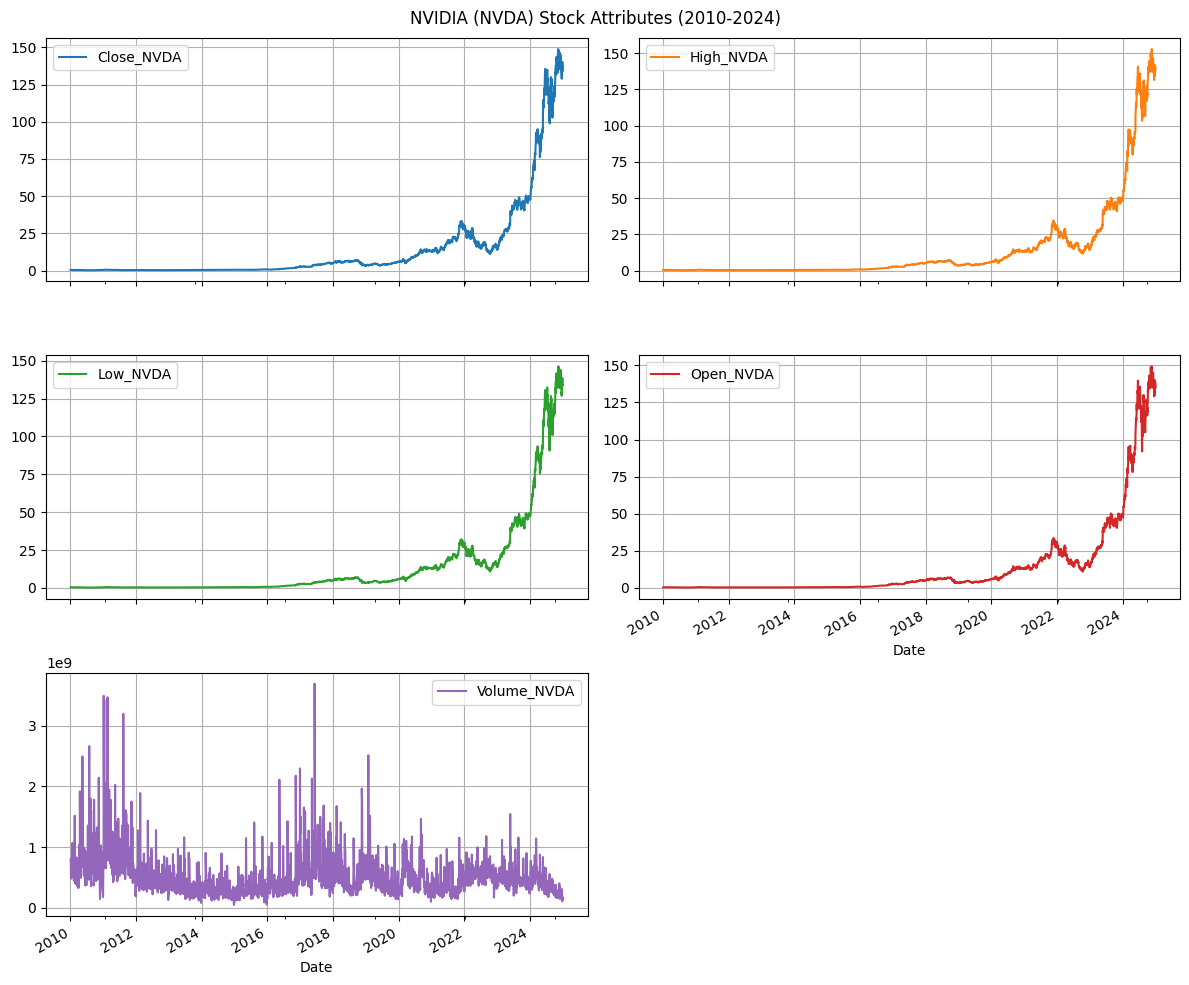

In [77]:
nvda_data = df.filter(regex='NVDA')['2010':'2024']
nvda_data.plot(subplots=True,
               figsize=(12, 10),
               title='NVIDIA (NVDA) Stock Attributes (2010-2024)',
               grid=True,
               layout=(3, 2))
plt.tight_layout()
plt.show()

--- Generating EDA Plots for NVDA ---


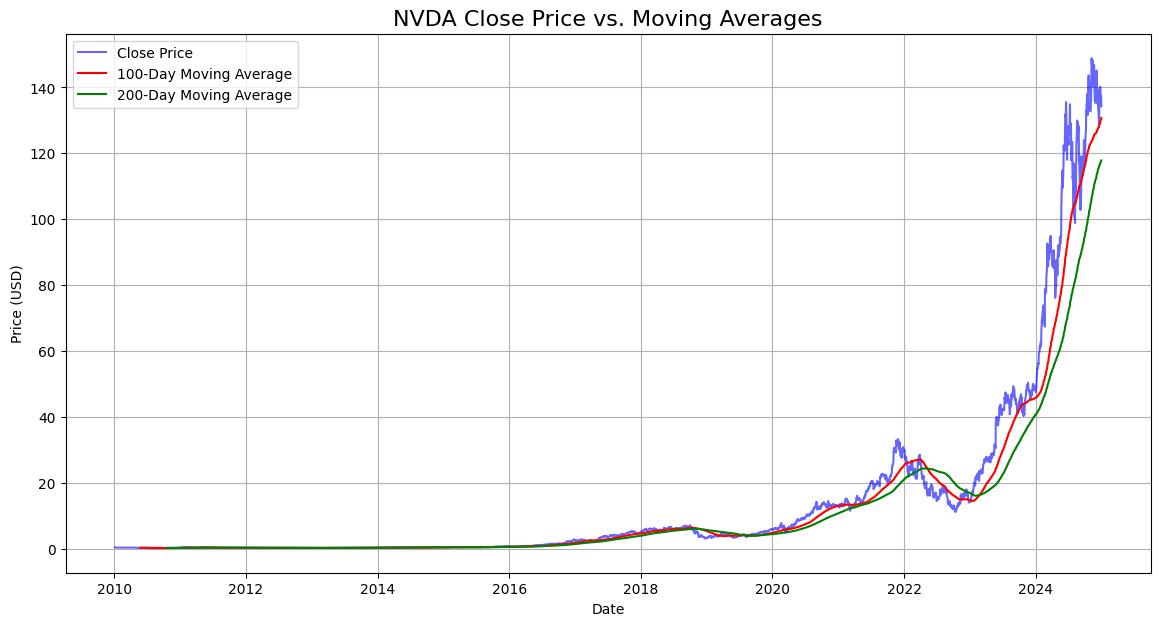

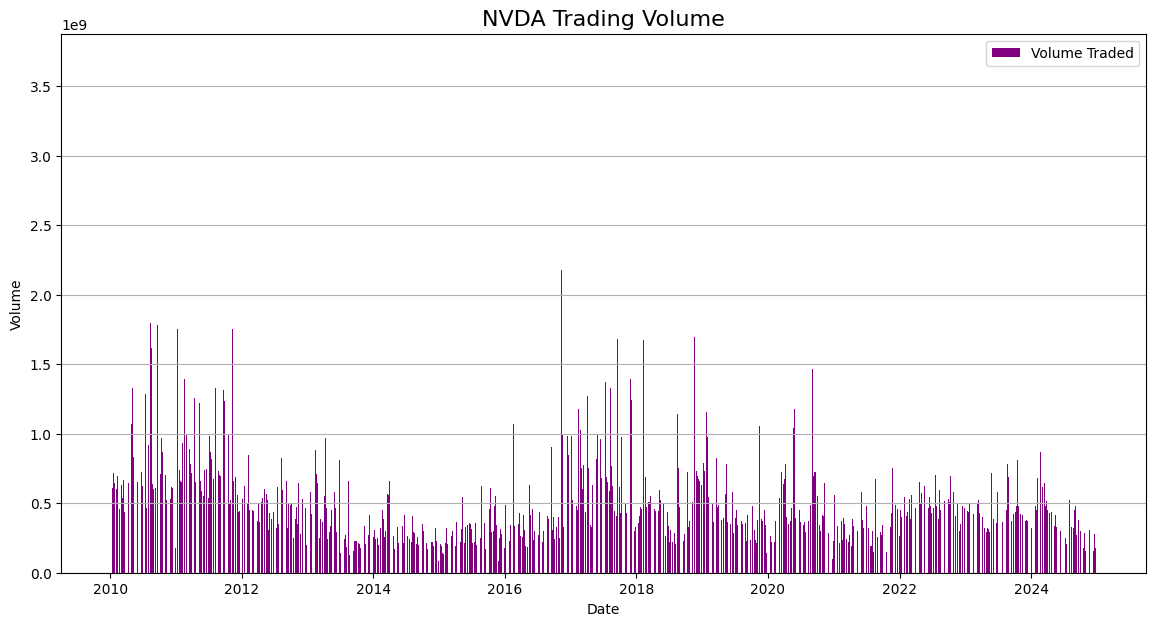

--- EDA for NVDA Complete ---



In [78]:
generate_eda_plots(df, 'NVDA')

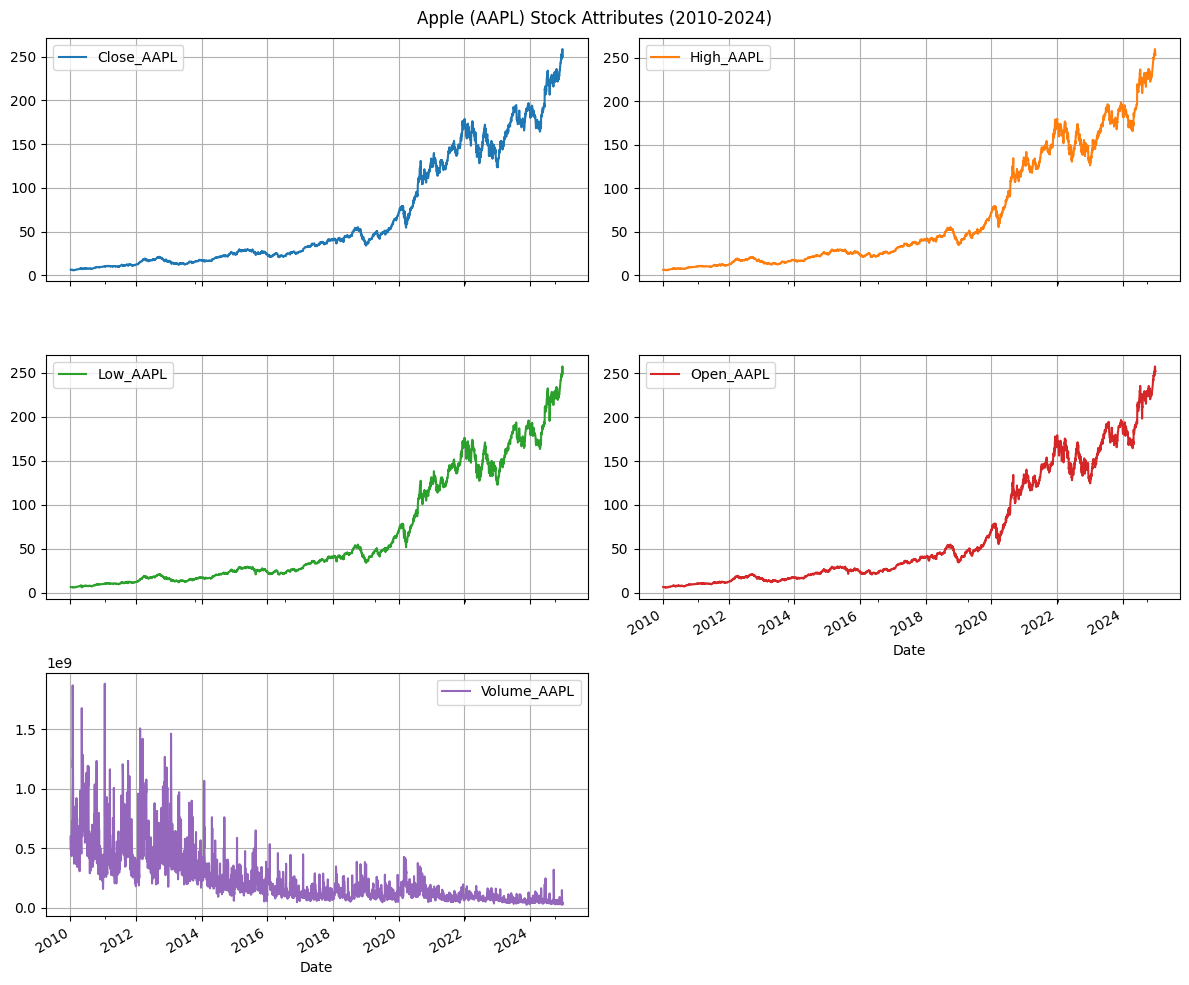

In [79]:
aapl_data = df.filter(regex='AAPL')['2010':'2024']
aapl_data.plot(subplots=True,
               figsize=(12, 10),
               title='Apple (AAPL) Stock Attributes (2010-2024)',
               grid=True,
               layout=(3, 2))
plt.tight_layout()
plt.show()

--- Generating EDA Plots for AAPL ---


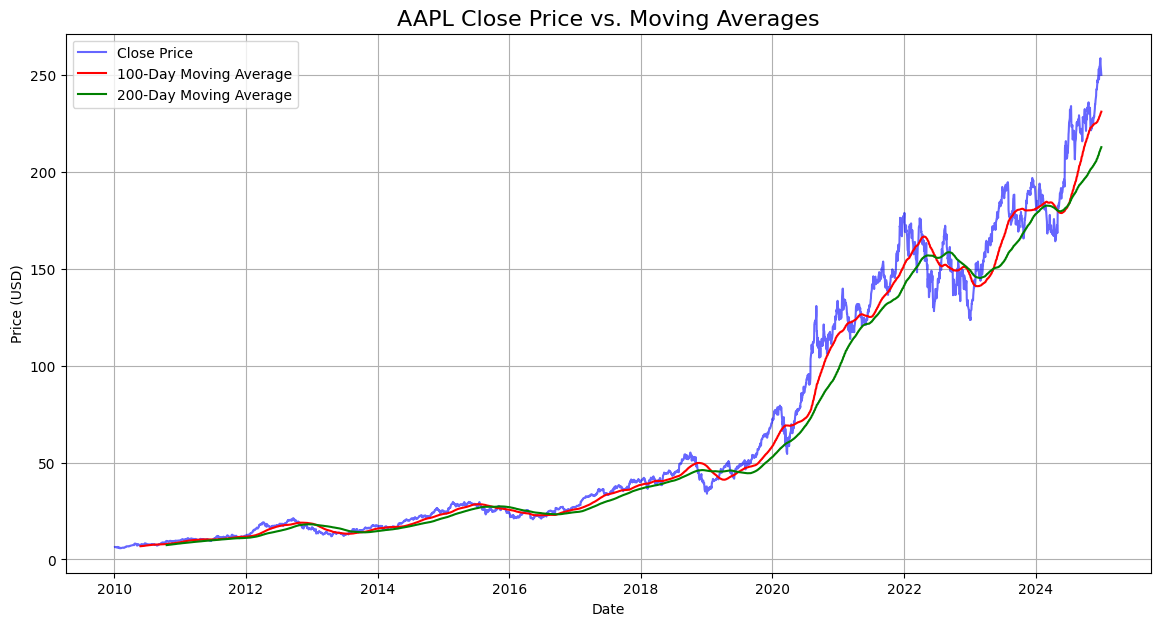

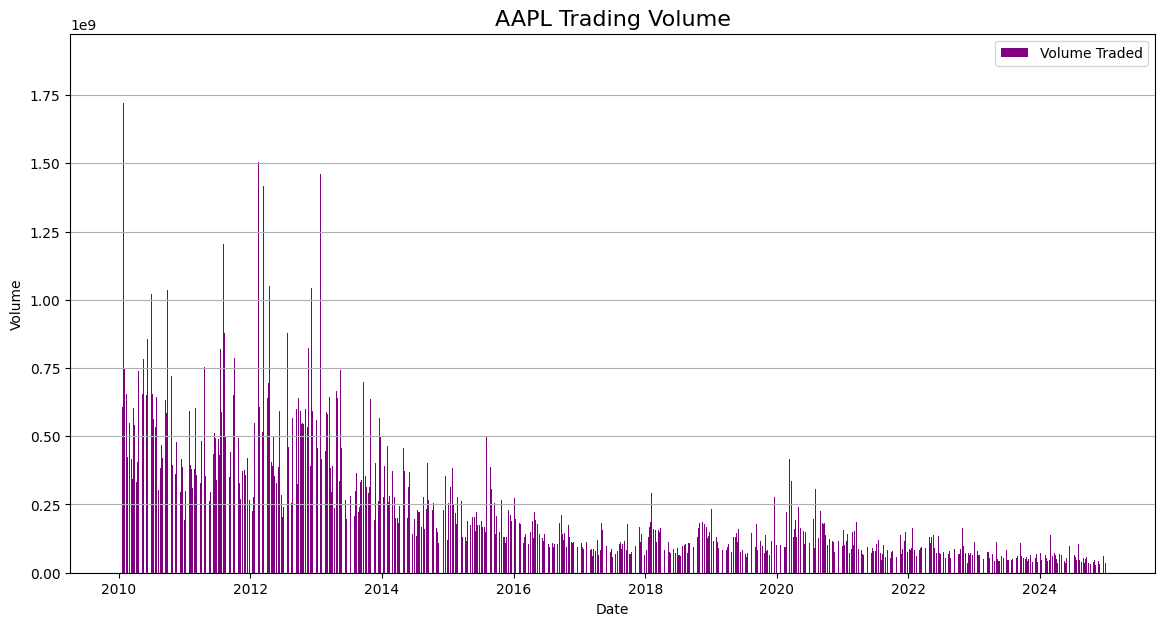

--- EDA for AAPL Complete ---



In [80]:
generate_eda_plots(df, 'AAPL')

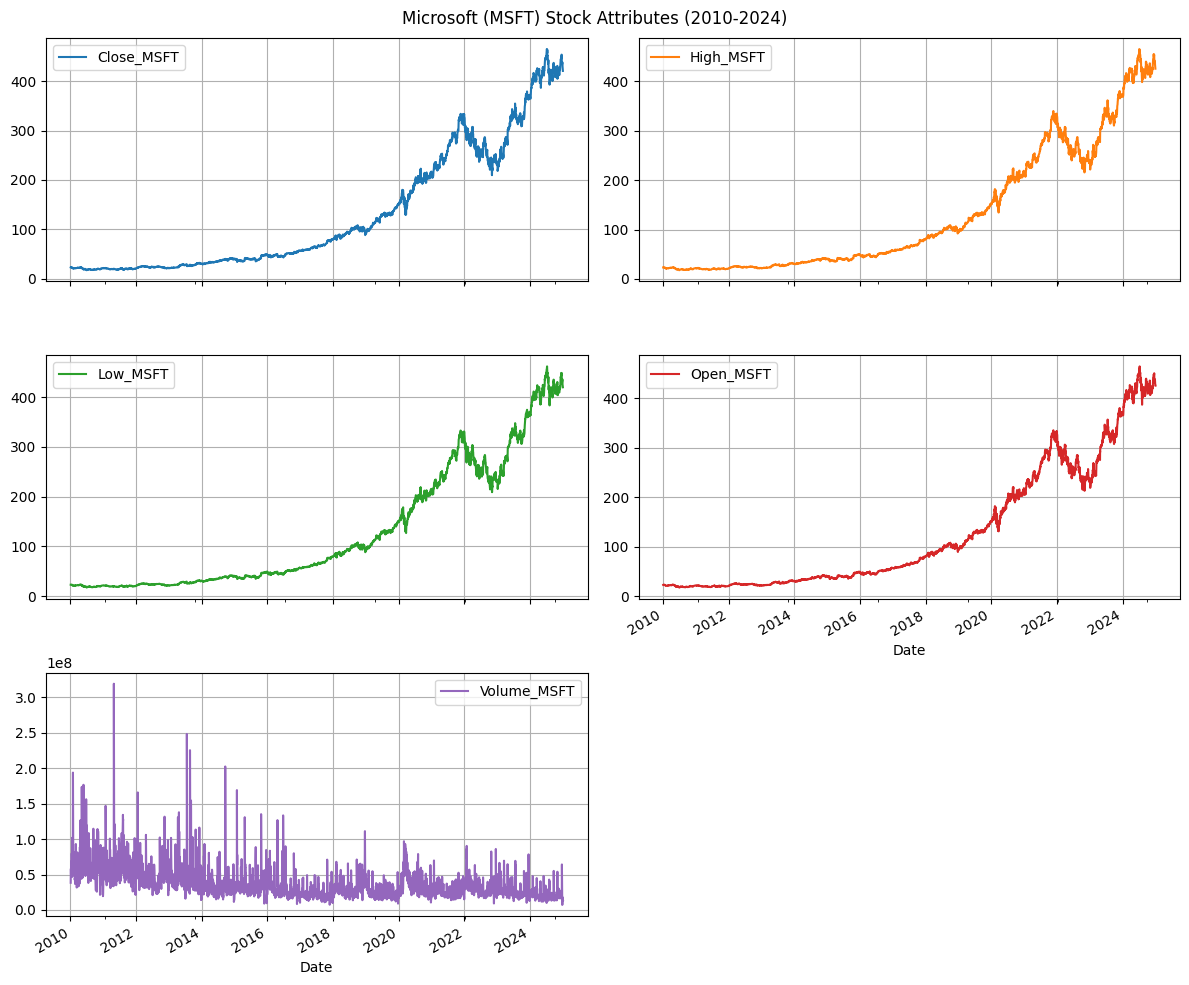

In [81]:
msft_data = df.filter(regex='MSFT')['2010':'2024']
msft_data.plot(subplots=True,
               figsize=(12, 10),
               title='Microsoft (MSFT) Stock Attributes (2010-2024)',
               grid=True,
               layout=(3, 2))
plt.tight_layout()
plt.show()

--- Generating EDA Plots for MSFT ---


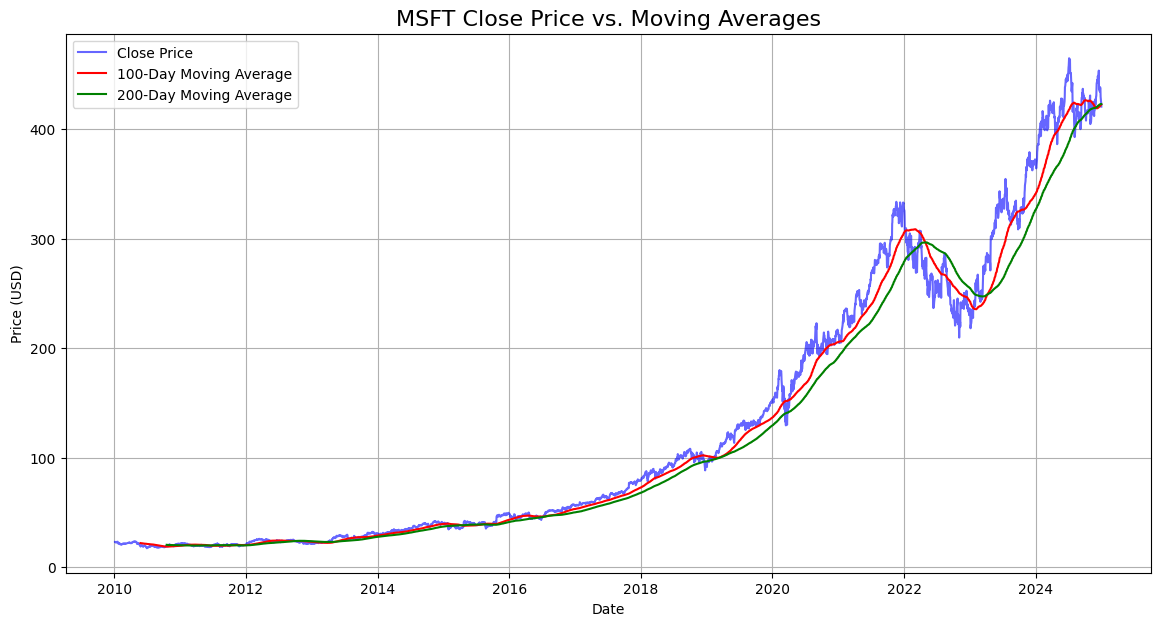

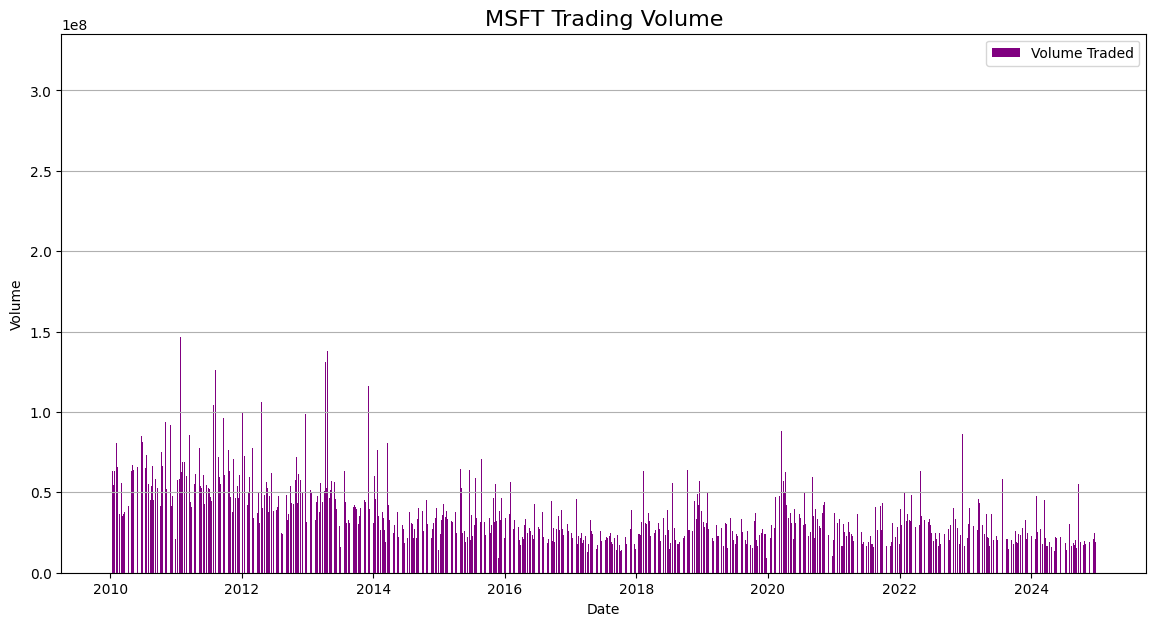

--- EDA for MSFT Complete ---



In [82]:
generate_eda_plots(df, 'MSFT')

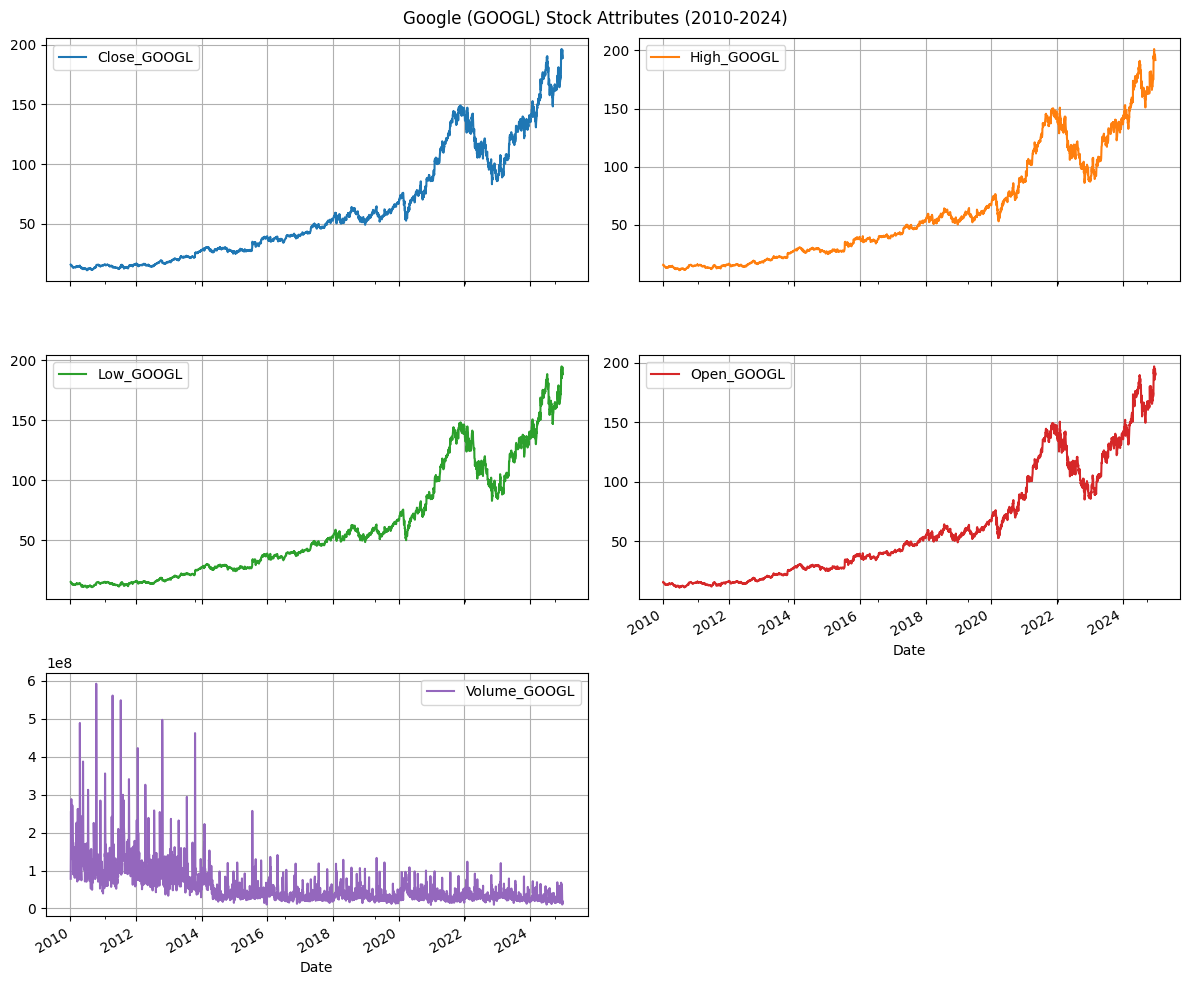

In [83]:
googl_data = df.filter(regex='GOOGL')['2010':'2024']
googl_data.plot(subplots=True,
                figsize=(12, 10),
                title='Google (GOOGL) Stock Attributes (2010-2024)',
                grid=True,
                layout=(3, 2))
plt.tight_layout()
plt.show()

--- Generating EDA Plots for GOOGL ---


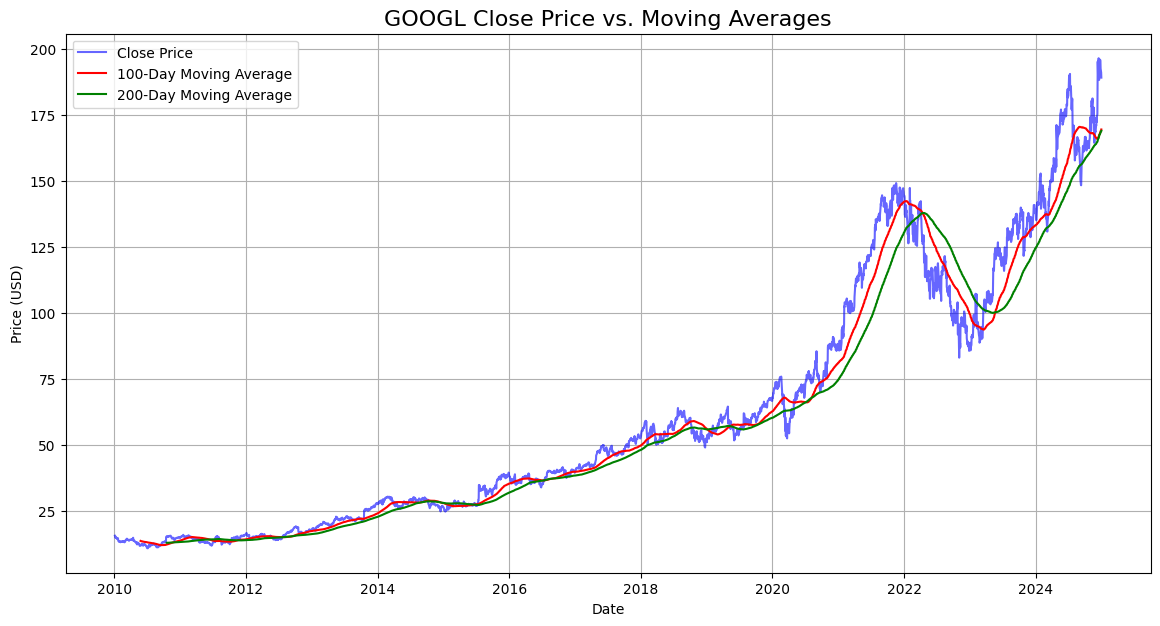

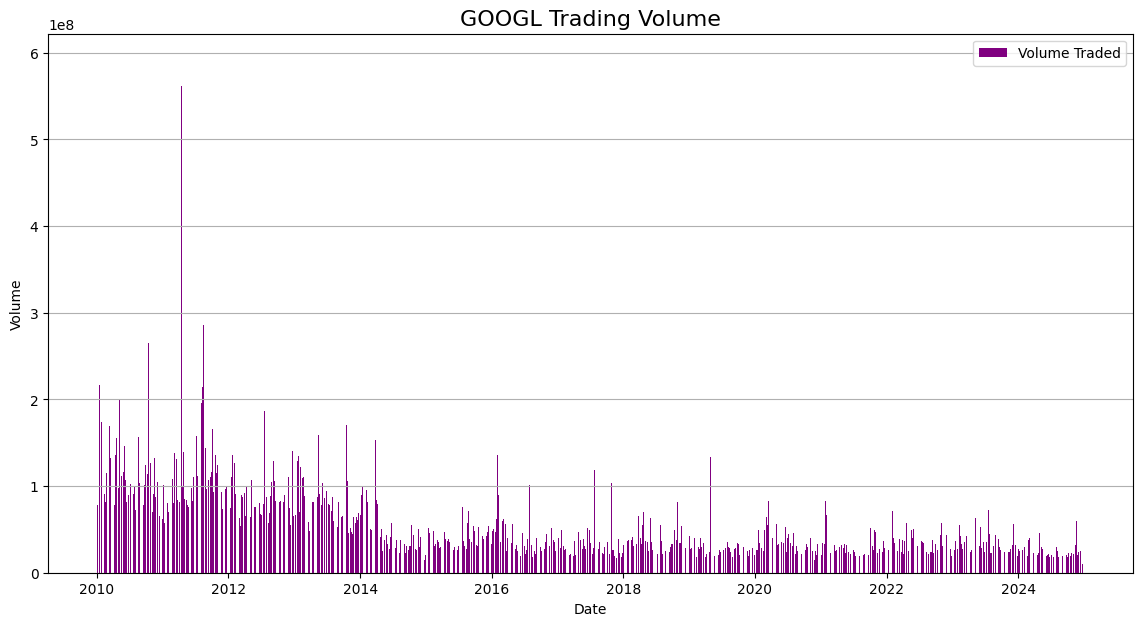

--- EDA for GOOGL Complete ---



In [84]:
generate_eda_plots(df, 'GOOGL')

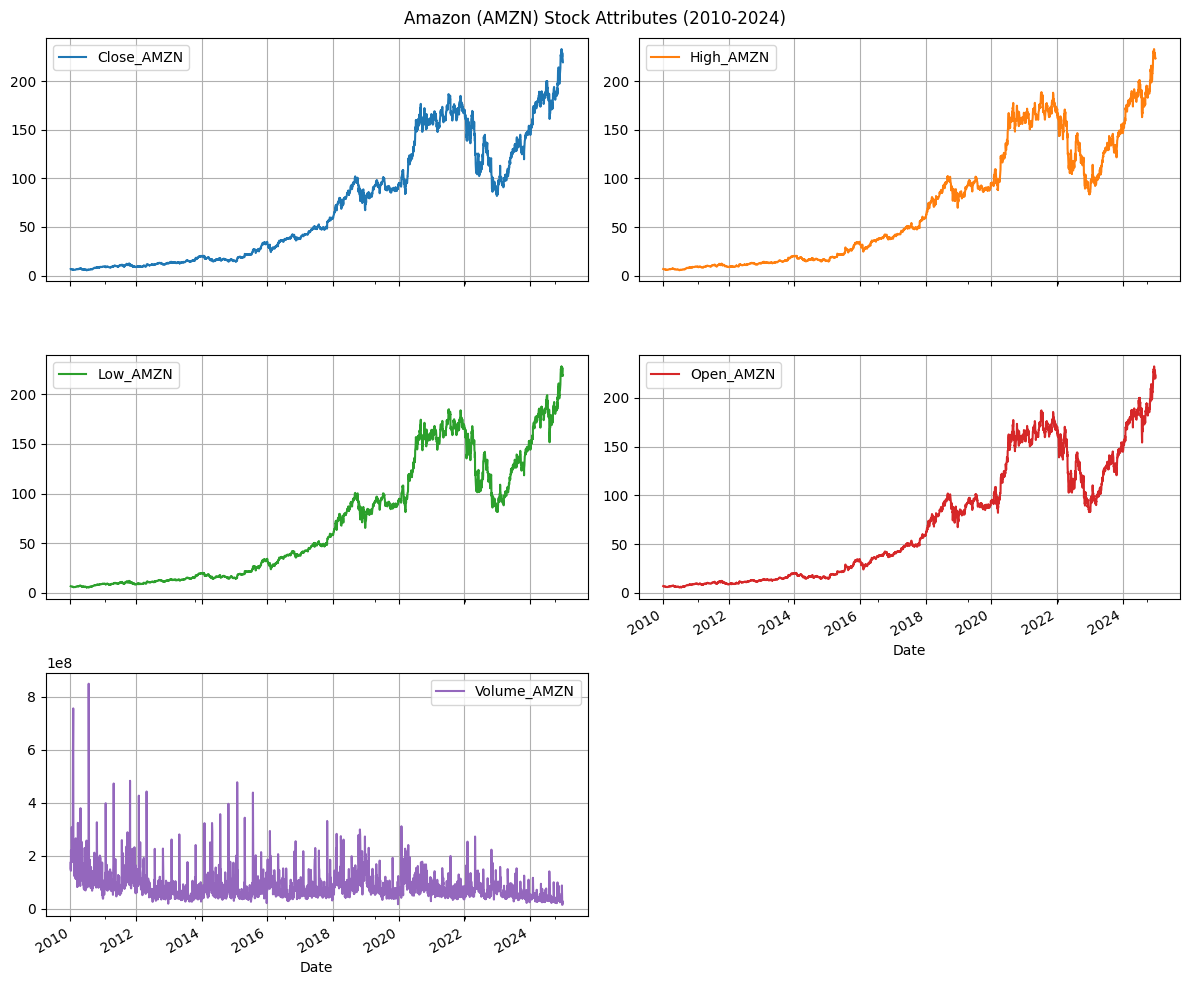

In [85]:
amzn_data = df.filter(regex='AMZN')['2010':'2024']
amzn_data.plot(subplots=True,
               figsize=(12, 10),
               title='Amazon (AMZN) Stock Attributes (2010-2024)',
               grid=True,
               layout=(3, 2))
plt.tight_layout()
plt.show()

--- Generating EDA Plots for AMZN ---


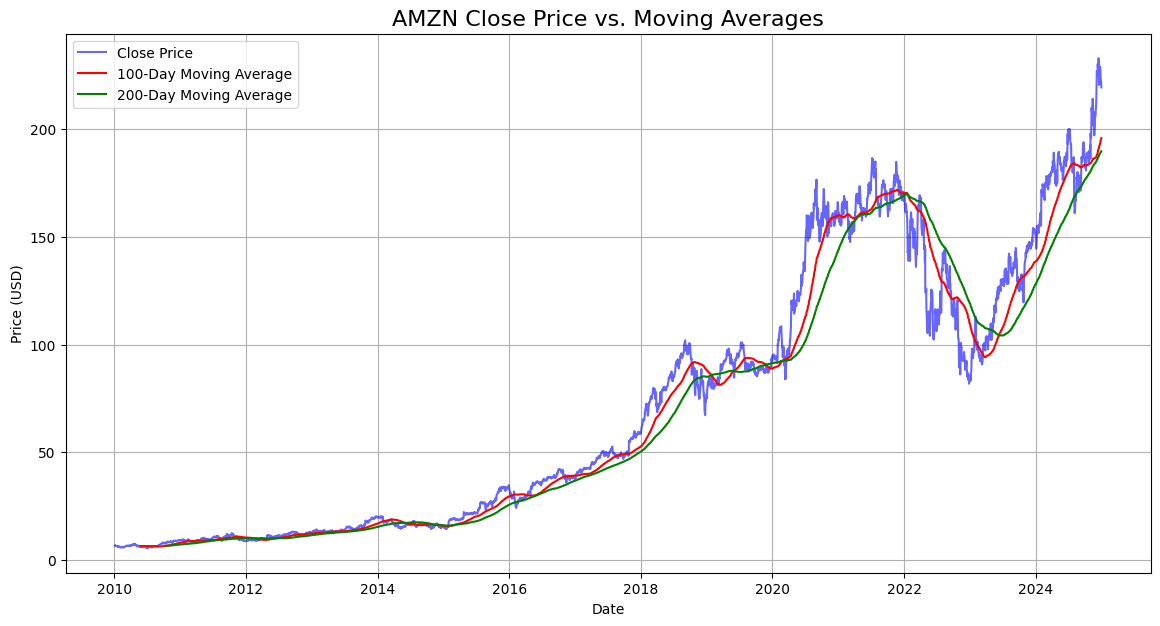

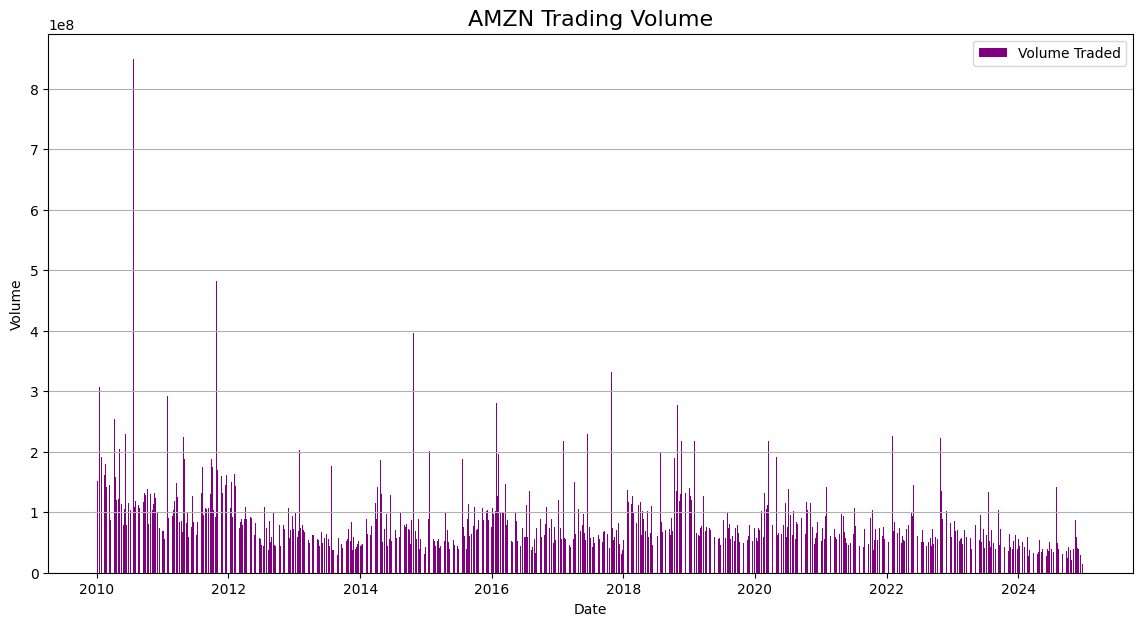

--- EDA for AMZN Complete ---



In [86]:
generate_eda_plots(df, 'AMZN')

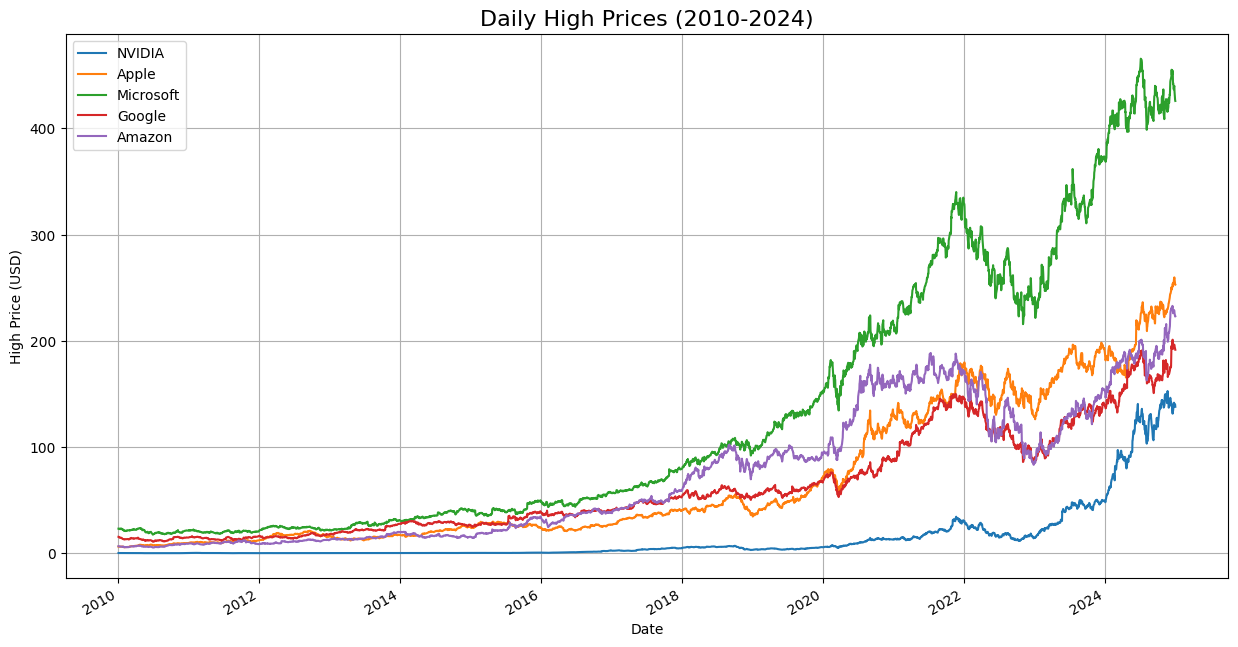

In [87]:
plt.figure(figsize=(15, 8))

df['High_NVDA'].plot()
df['High_AAPL'].plot()
df['High_MSFT'].plot()
df['High_GOOGL'].plot()
df['High_AMZN'].plot()

plt.title('Daily High Prices (2010-2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.legend(['NVIDIA', 'Apple', 'Microsoft', 'Google', 'Amazon'])
plt.grid(True)
plt.show()

---
## **3. Comparative Analysis: Benchmarking the Tech Giants**
While individual analysis is insightful, comparing the stocks directly reveals market leadership and relative performance.

### **3.1. The Need for Normalization**
A direct plot of stock prices can be deceiving due to their different price scales (e.g., NVIDIA's stock price is much higher than Apple's after splits). To create a fair comparison of growth, we **normalize** the prices. By setting the starting 'High' price of every stock to a common baseline of 100, we can effectively visualize their percentage growth over time. This method clearly answers the question: "If you had invested $100 in each of these stocks in 2010, which would have performed best?"

### **3.2. Expanding Windows: A Look at Cumulative Performance and Risk**
The expanding window analysis provides a dynamic view of a stock's history.
* **Expanding Mean:** This is a cumulative average that shows the long-term momentum of the stock. A steadily increasing expanding mean indicates strong and consistent historical performance.
* **Expanding Standard Deviation:** This is a measure of cumulative volatility, or **risk**. A rising line indicates that the stock's price fluctuations have been increasing over time, suggesting it has become a more volatile and potentially riskier asset.

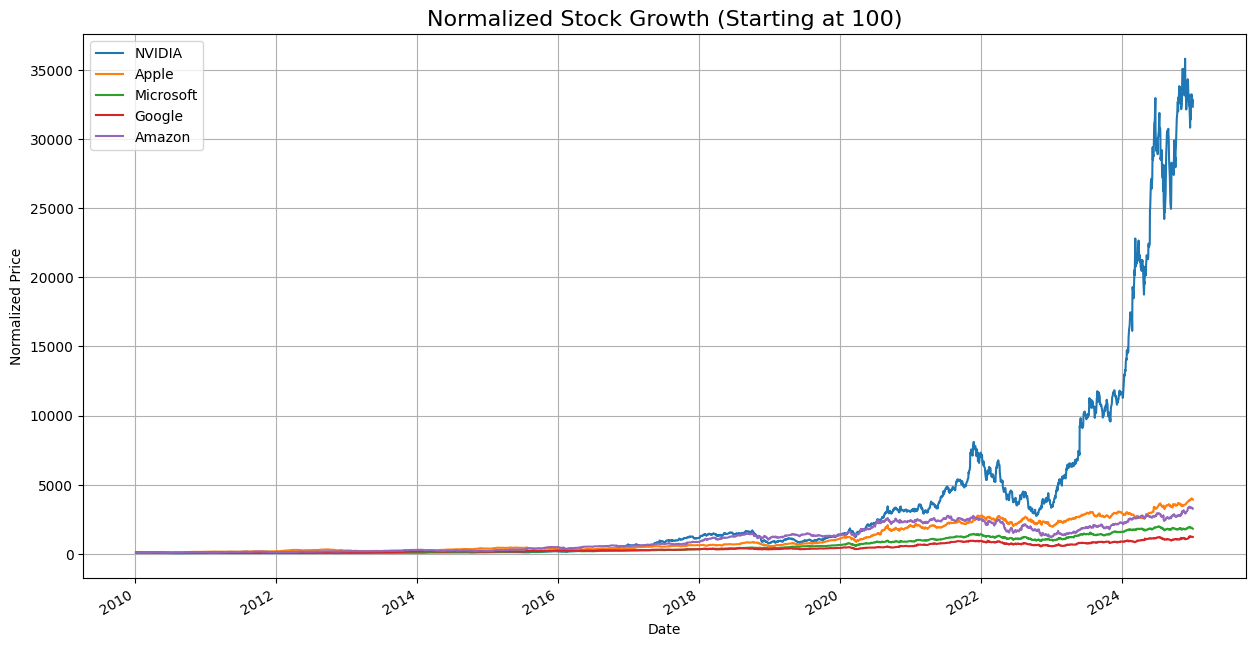

In [88]:
# --- Normalized 'High' Price Comparison ---

# Set the figure size for better readability
plt.figure(figsize=(15, 8))

# Normalize each stock's 'High' price to a starting value of 100
(df['High_NVDA'].div(df['High_NVDA'].iloc[0]).mul(100)).plot()
(df['High_AAPL'].div(df['High_AAPL'].iloc[0]).mul(100)).plot()
(df['High_MSFT'].div(df['High_MSFT'].iloc[0]).mul(100)).plot()
(df['High_GOOGL'].div(df['High_GOOGL'].iloc[0]).mul(100)).plot()
(df['High_AMZN'].div(df['High_AMZN'].iloc[0]).mul(100)).plot()

# Add a title, labels, and legend
plt.title('Normalized Stock Growth (Starting at 100)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(['NVIDIA', 'Apple', 'Microsoft', 'Google', 'Amazon'])
plt.grid(True)
plt.show()

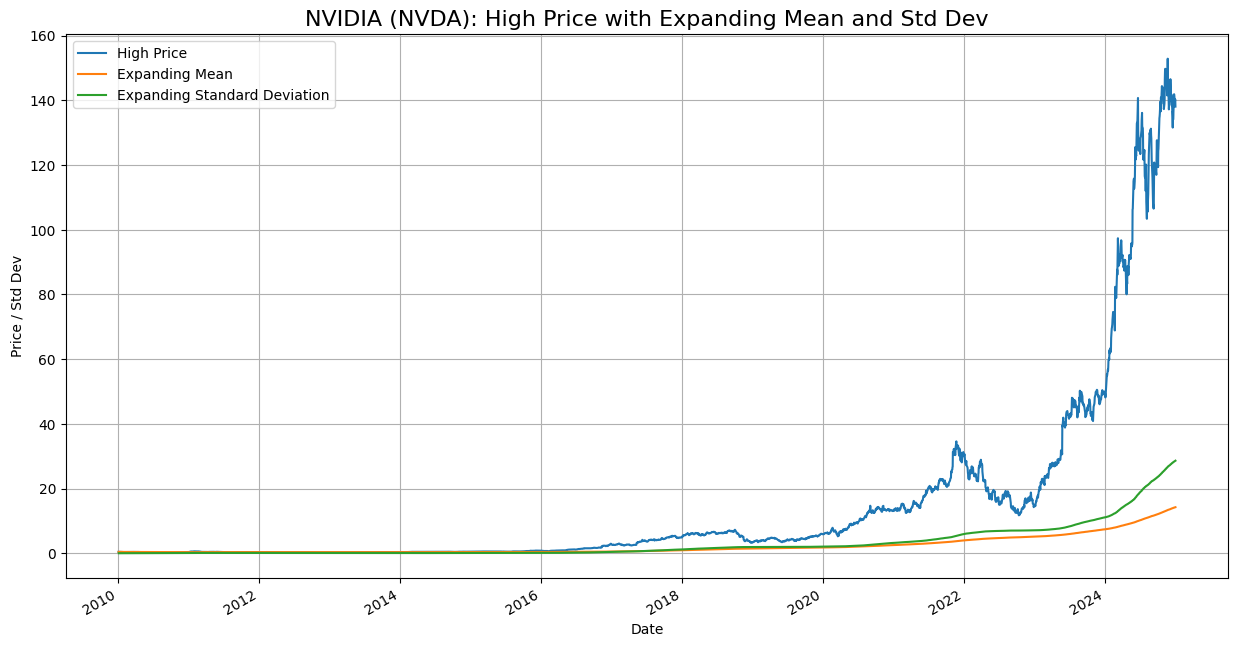

In [89]:
nvda_expanding_mean = df['High_NVDA'].expanding().mean()
nvda_expanding_std = df['High_NVDA'].expanding().std()

plt.figure(figsize=(15, 8))
df['High_NVDA'].plot()
nvda_expanding_mean.plot()
nvda_expanding_std.plot()

plt.title('NVIDIA (NVDA): High Price with Expanding Mean and Std Dev', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price / Std Dev')
plt.legend(['High Price', 'Expanding Mean', 'Expanding Standard Deviation'])
plt.grid(True)
plt.show()

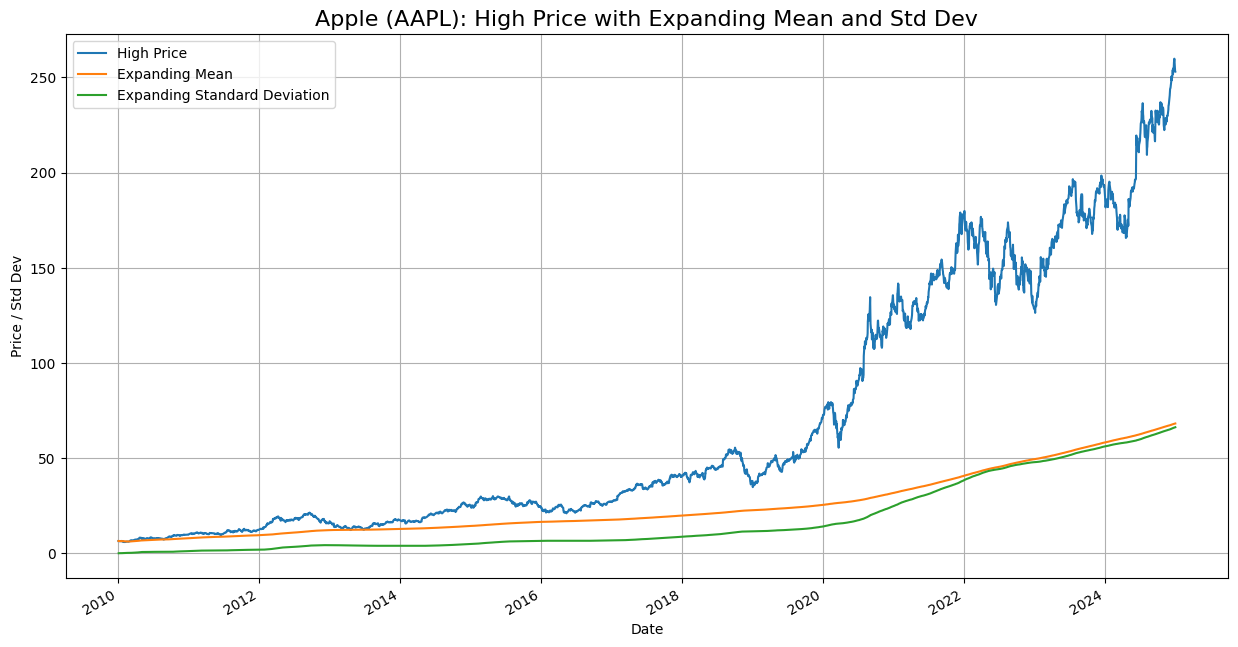

In [90]:
aapl_expanding_mean = df['High_AAPL'].expanding().mean()
aapl_expanding_std = df['High_AAPL'].expanding().std()

plt.figure(figsize=(15, 8))
df['High_AAPL'].plot()
aapl_expanding_mean.plot()
aapl_expanding_std.plot()

plt.title('Apple (AAPL): High Price with Expanding Mean and Std Dev', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price / Std Dev')
plt.legend(['High Price', 'Expanding Mean', 'Expanding Standard Deviation'])
plt.grid(True)
plt.show()

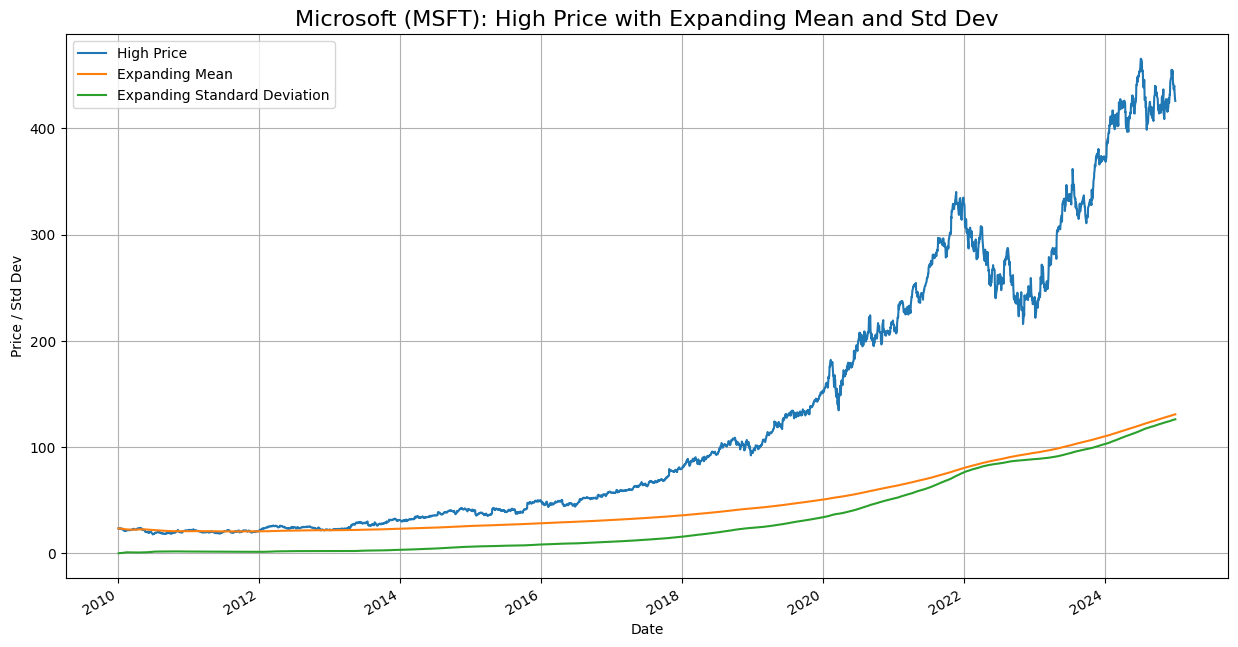

In [91]:
msft_expanding_mean = df['High_MSFT'].expanding().mean()
msft_expanding_std = df['High_MSFT'].expanding().std()

plt.figure(figsize=(15, 8))
df['High_MSFT'].plot()
msft_expanding_mean.plot()
msft_expanding_std.plot()

plt.title('Microsoft (MSFT): High Price with Expanding Mean and Std Dev', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price / Std Dev')
plt.legend(['High Price', 'Expanding Mean', 'Expanding Standard Deviation'])
plt.grid(True)
plt.show()

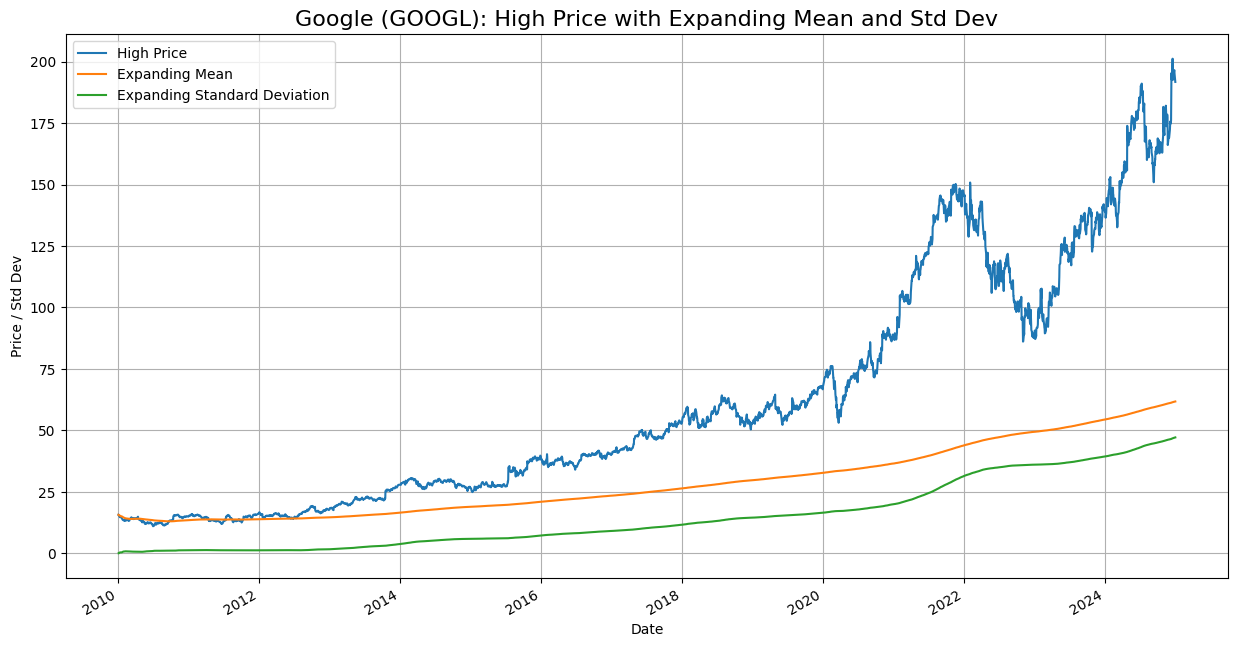

In [92]:
googl_expanding_mean = df['High_GOOGL'].expanding().mean()
googl_expanding_std = df['High_GOOGL'].expanding().std()

plt.figure(figsize=(15, 8))
df['High_GOOGL'].plot()
googl_expanding_mean.plot()
googl_expanding_std.plot()

plt.title('Google (GOOGL): High Price with Expanding Mean and Std Dev', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price / Std Dev')
plt.legend(['High Price', 'Expanding Mean', 'Expanding Standard Deviation'])
plt.grid(True)
plt.show()

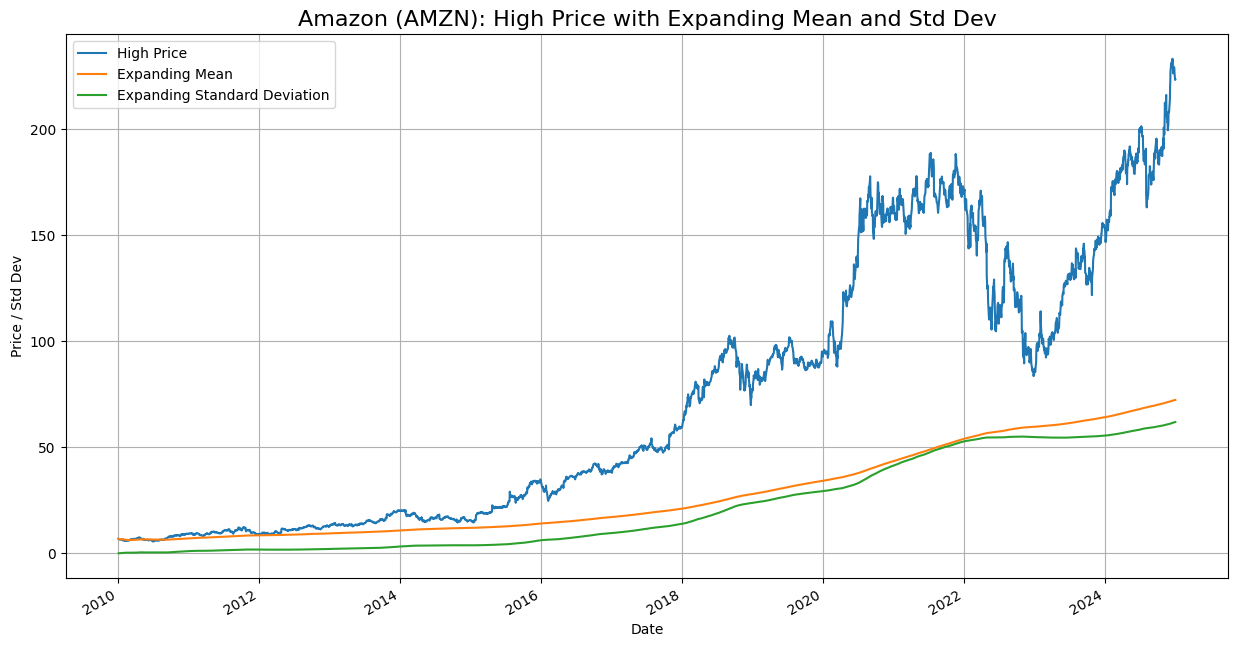

In [93]:
amzn_expanding_mean = df['High_AMZN'].expanding().mean()
amzn_expanding_std = df['High_AMZN'].expanding().std()

plt.figure(figsize=(15, 8))
df['High_AMZN'].plot()
amzn_expanding_mean.plot()
amzn_expanding_std.plot()

plt.title('Amazon (AMZN): High Price with Expanding Mean and Std Dev', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price / Std Dev')
plt.legend(['High Price', 'Expanding Mean', 'Expanding Standard Deviation'])
plt.grid(True)
plt.show()

---
## **4. Statistical Decomposition of Time-Series Data**
To statistically validate the patterns observed during EDA, we decompose the time-series data. This technique separates the stock price into three fundamental components, allowing us to understand its underlying structure.
* **Trend:** This component captures the long-term trajectory of the stock price. For all the tech stocks in our dataset, we expect to see a strong upward trend, reflecting their growth over the last decade.
* **Seasonality:** This component isolates any repeating, fixed-period patterns. For stock data, this might capture annual or quarterly cycles related to business performance or market psychology.
* **Residuals:** This component represents the "noise" or random, unpredictable fluctuations that remain after the trend and seasonality have been removed. A high degree of residuals indicates significant market irregularity.

This analysis confirms that our data is not random; it possesses a strong, learnable trend, which justifies the use of a sophisticated time-series model like an LSTM.

In [94]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11, 9

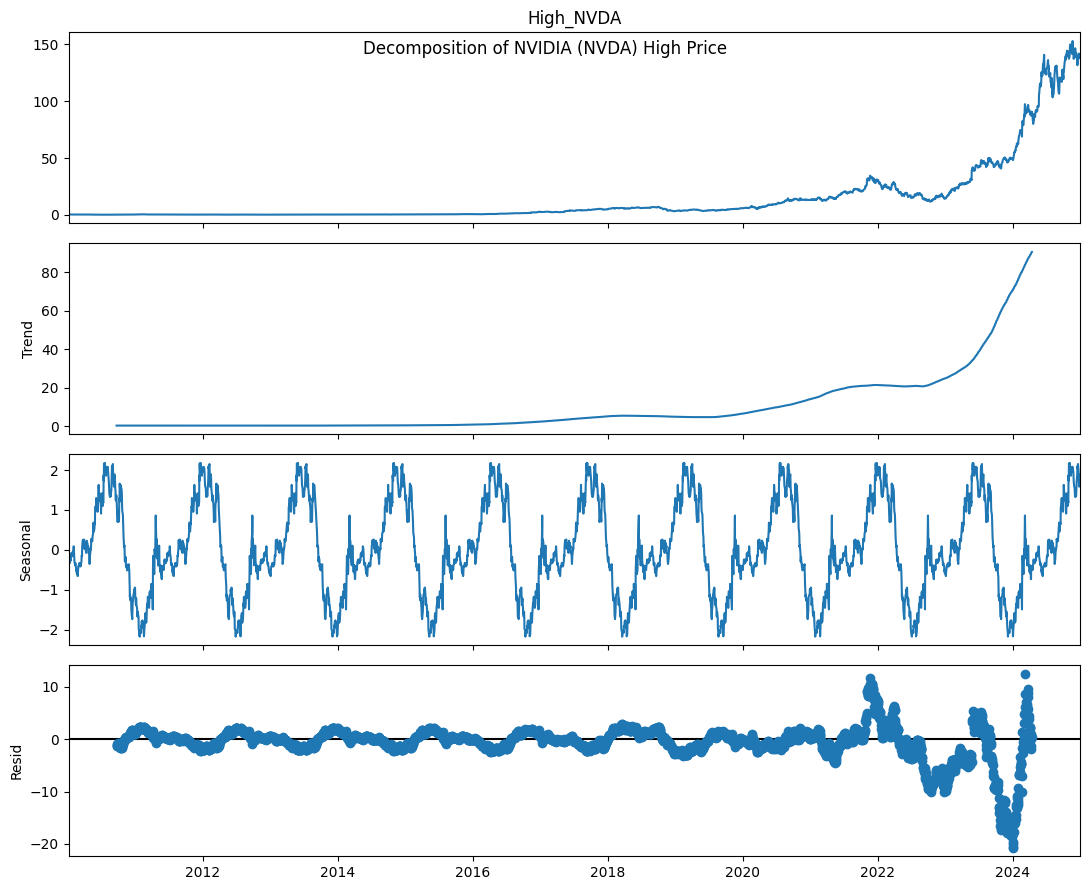

In [95]:
decomposed_nvda_high = sm.tsa.seasonal_decompose(df["High_NVDA"], period=360)
figure = decomposed_nvda_high.plot()
plt.suptitle('Decomposition of NVIDIA (NVDA) High Price', y=0.95)
plt.show()

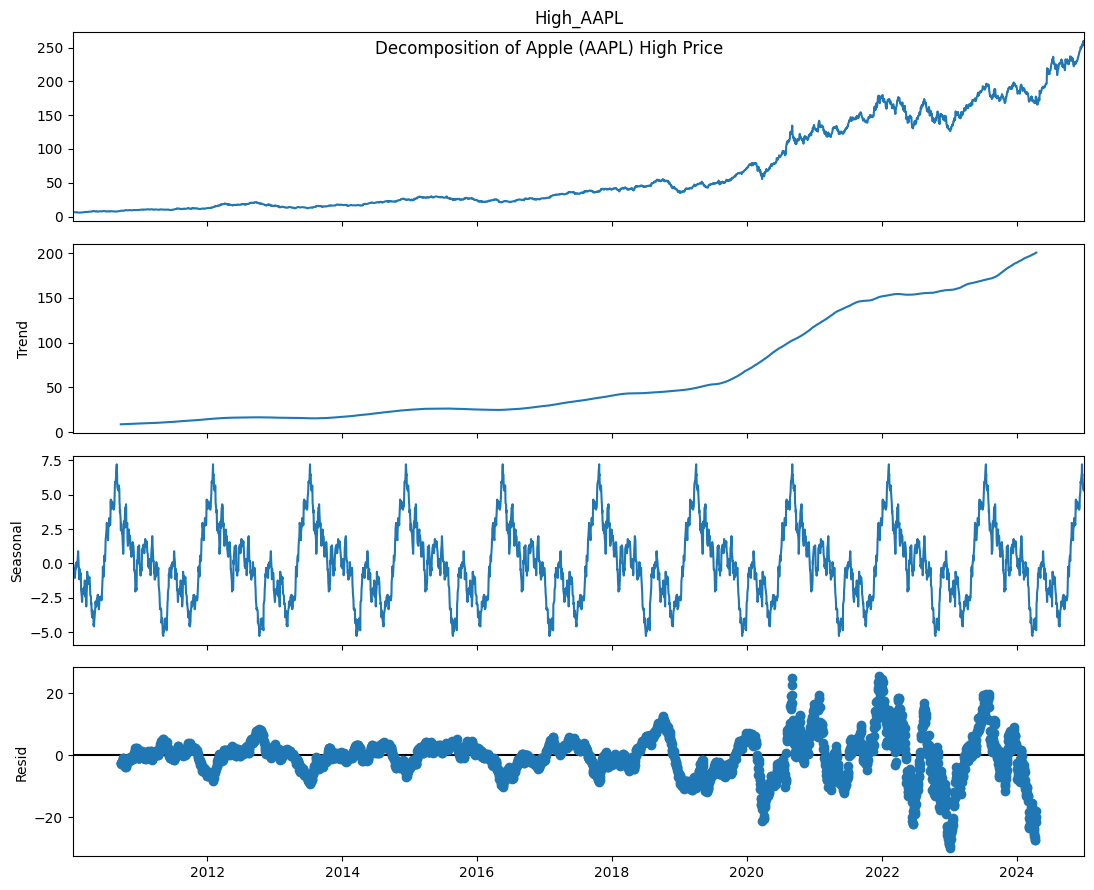

In [96]:
decomposed_aapl_high = sm.tsa.seasonal_decompose(df["High_AAPL"], period=360)
figure = decomposed_aapl_high.plot()
plt.suptitle('Decomposition of Apple (AAPL) High Price', y=0.95)
plt.show()

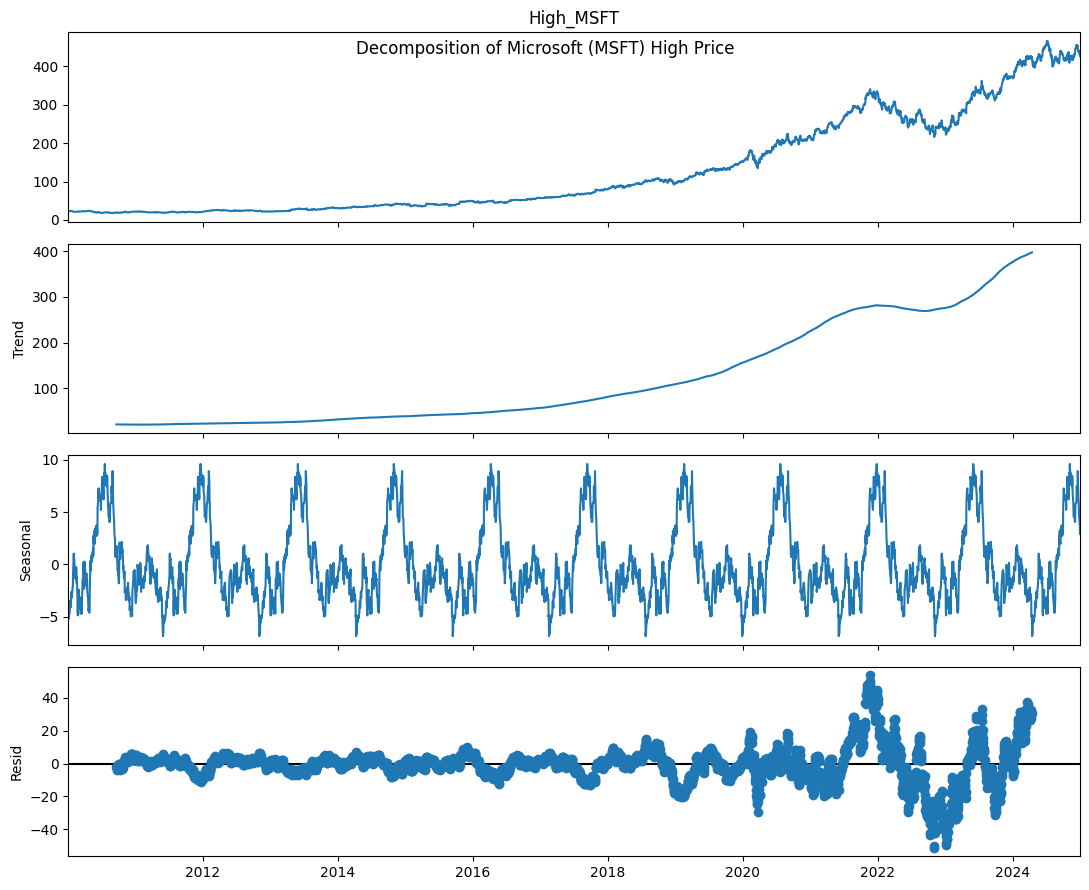

In [97]:
decomposed_msft_high = sm.tsa.seasonal_decompose(df["High_MSFT"], period=360)
figure = decomposed_msft_high.plot()
plt.suptitle('Decomposition of Microsoft (MSFT) High Price', y=0.95)
plt.show()

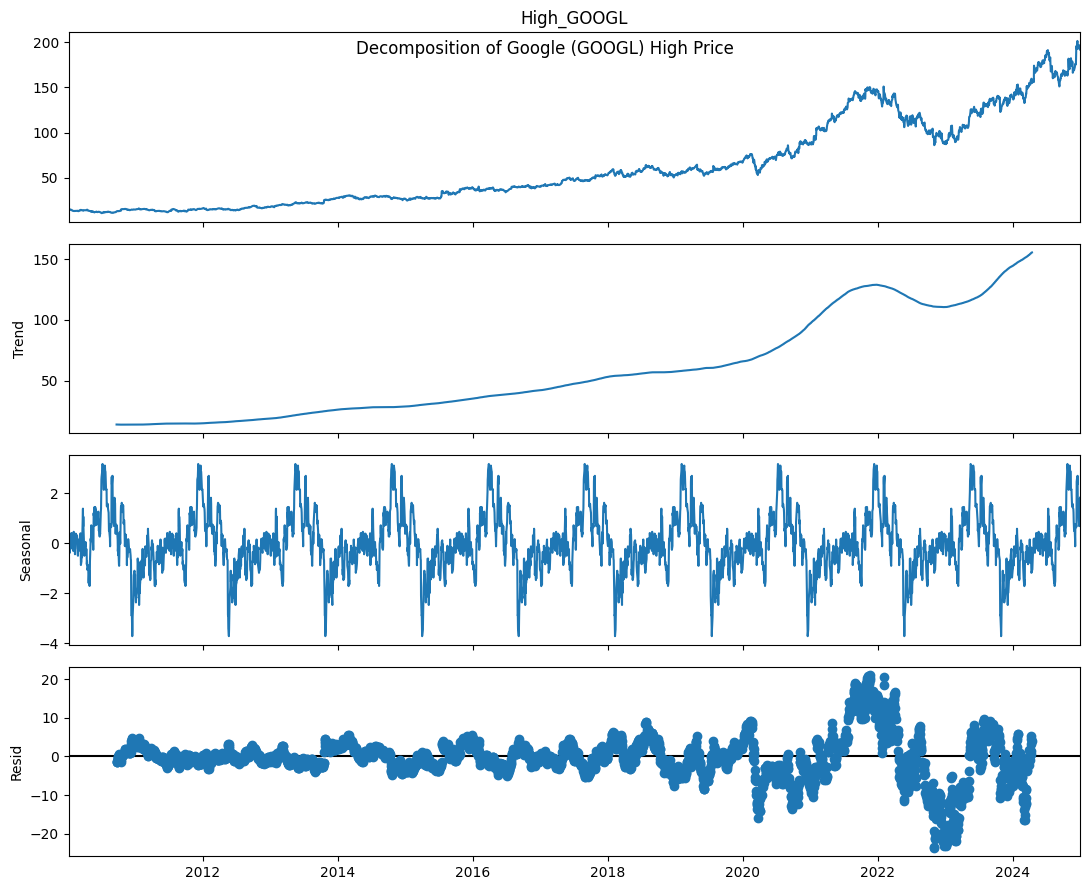

In [98]:
decomposed_googl_high = sm.tsa.seasonal_decompose(df["High_GOOGL"], period=360)
figure = decomposed_googl_high.plot()
plt.suptitle('Decomposition of Google (GOOGL) High Price', y=0.95)
plt.show()

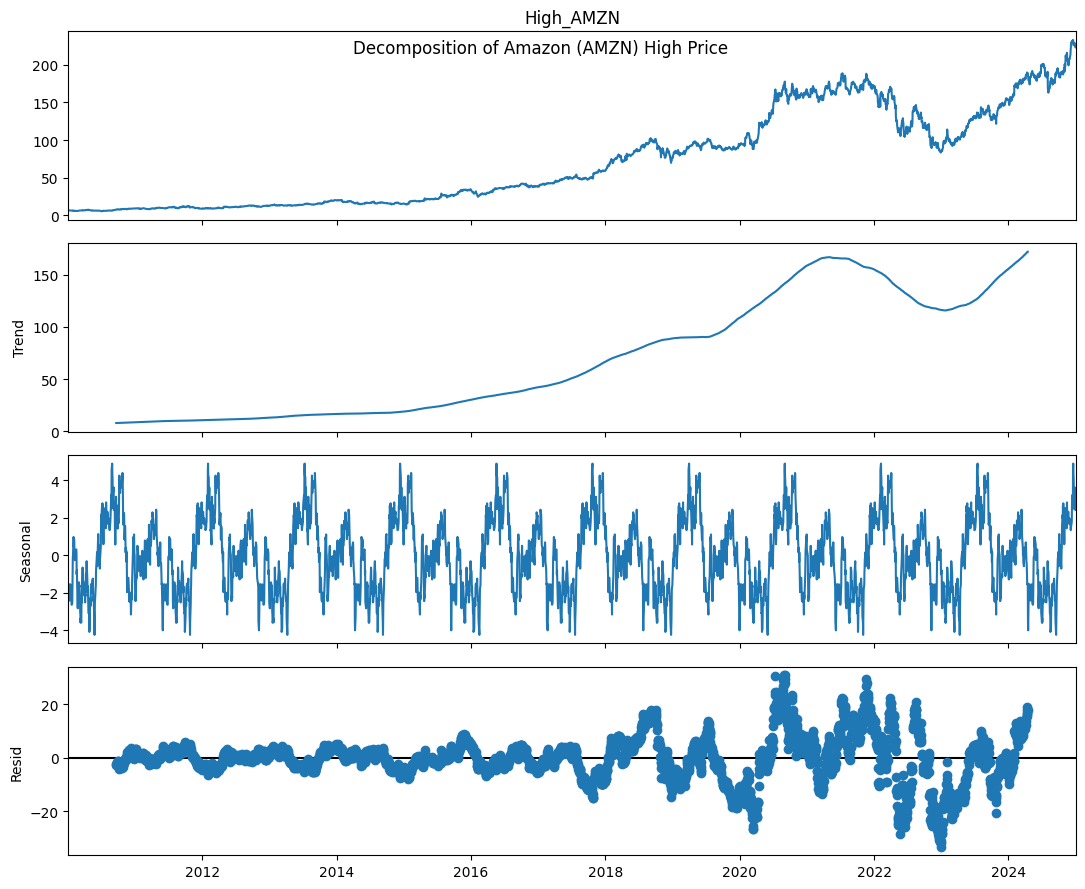

In [99]:
decomposed_amzn_high = sm.tsa.seasonal_decompose(df["High_AMZN"], period=360)
figure = decomposed_amzn_high.plot()
plt.suptitle('Decomposition of Amazon (AMZN) High Price', y=0.95)
plt.show()

In [100]:
def run_lstm_forecasting(dataframe, ticker):
    """
    Trains an LSTM model and plots the prediction against actual prices.
    """
    print(f"--- Starting LSTM Forecasting for {ticker} ---")

    # 1. Prepare Data
    close_col = f'Close_{ticker}'
    data = dataframe.filter([close_col])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * 0.8))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:int(training_data_len), :]

    X_train, y_train = [], []
    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # 2. Build and Train LSTM Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(f"Training LSTM model for {ticker}...")
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

    # 3. Create Test Data and Predict
    test_data = scaled_data[training_data_len - 60:, :]
    X_test = []
    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # 4. Visualize the Final Prediction
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f'{ticker} - Model Prediction vs. Actual Price', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)
    plt.plot(train[close_col], label='Train History')
    plt.plot(valid[close_col], color='blue', label='Actual Price (Validation)')
    plt.plot(valid['Predictions'], color='red', label='Predicted Price')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.show()

    print(f"--- Forecasting for {ticker} Complete ---\n")

--- Starting LSTM Forecasting for NVDA ---
Training LSTM model for NVDA...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/tmp/ipython-input-1562499477.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


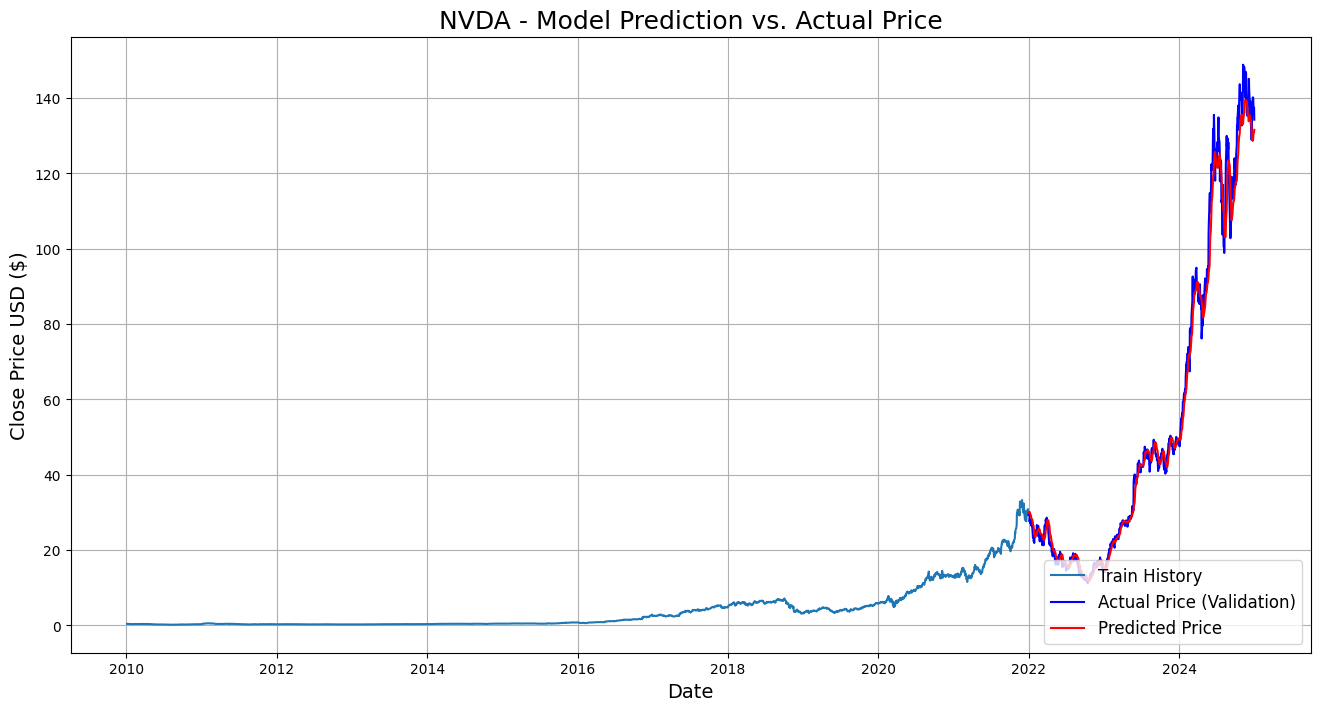

--- Forecasting for NVDA Complete ---



In [101]:
run_lstm_forecasting(df, 'NVDA')

--- Starting LSTM Forecasting for AAPL ---
Training LSTM model for AAPL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


/tmp/ipython-input-1562499477.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


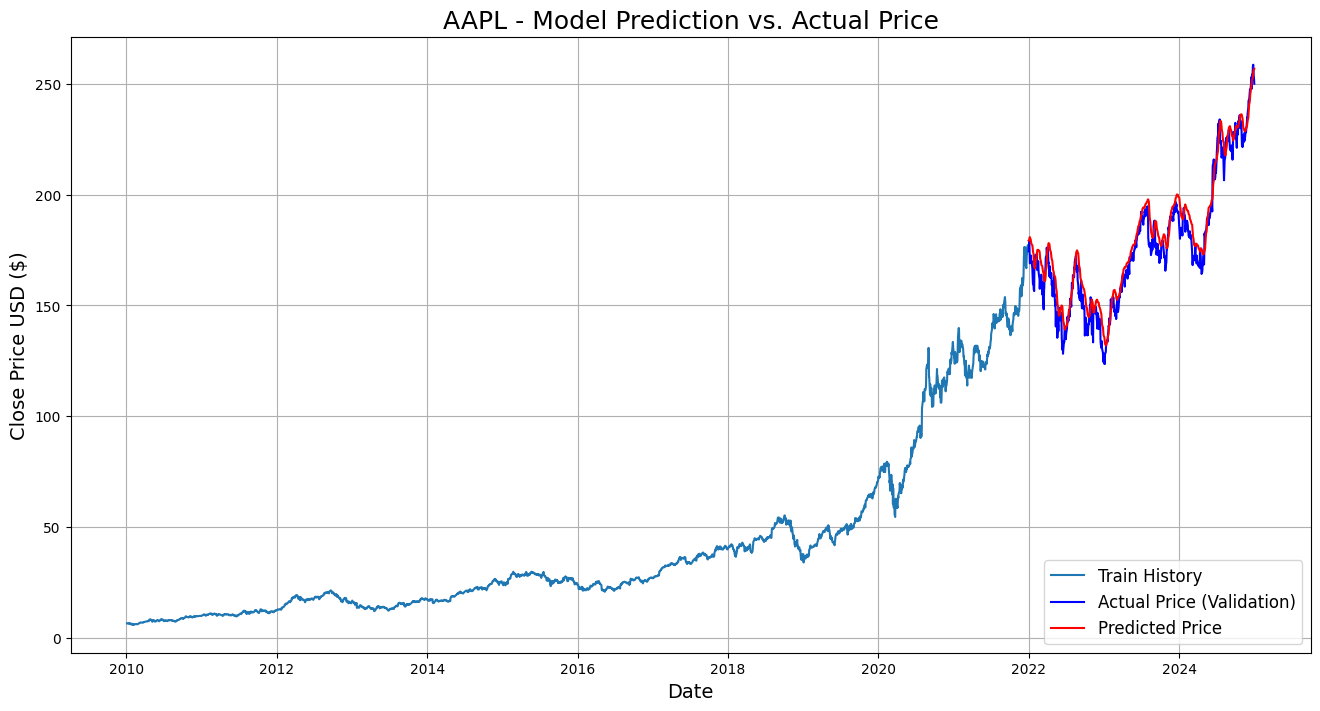

--- Forecasting for AAPL Complete ---



In [102]:
run_lstm_forecasting(df, 'AAPL')

--- Starting LSTM Forecasting for MSFT ---
Training LSTM model for MSFT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/tmp/ipython-input-1562499477.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


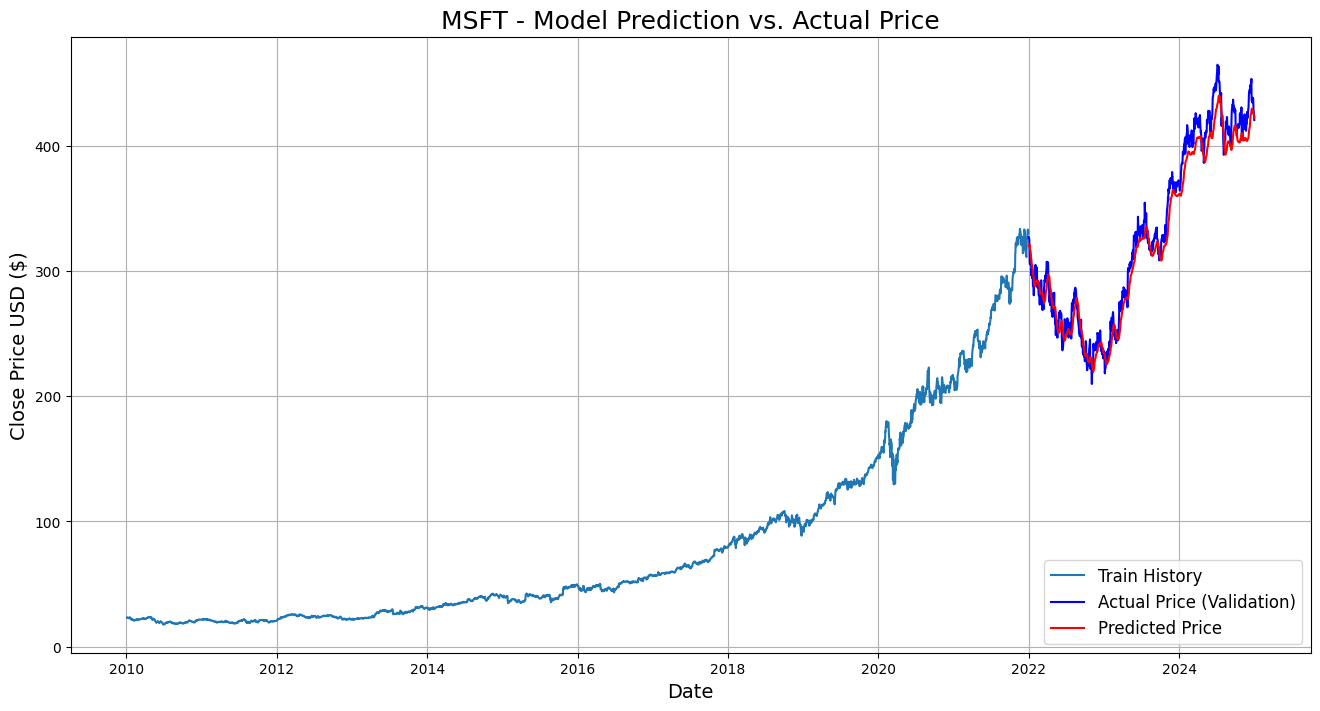

--- Forecasting for MSFT Complete ---



In [103]:
run_lstm_forecasting(df, 'MSFT')

--- Starting LSTM Forecasting for GOOGL ---
Training LSTM model for GOOGL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/tmp/ipython-input-1562499477.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


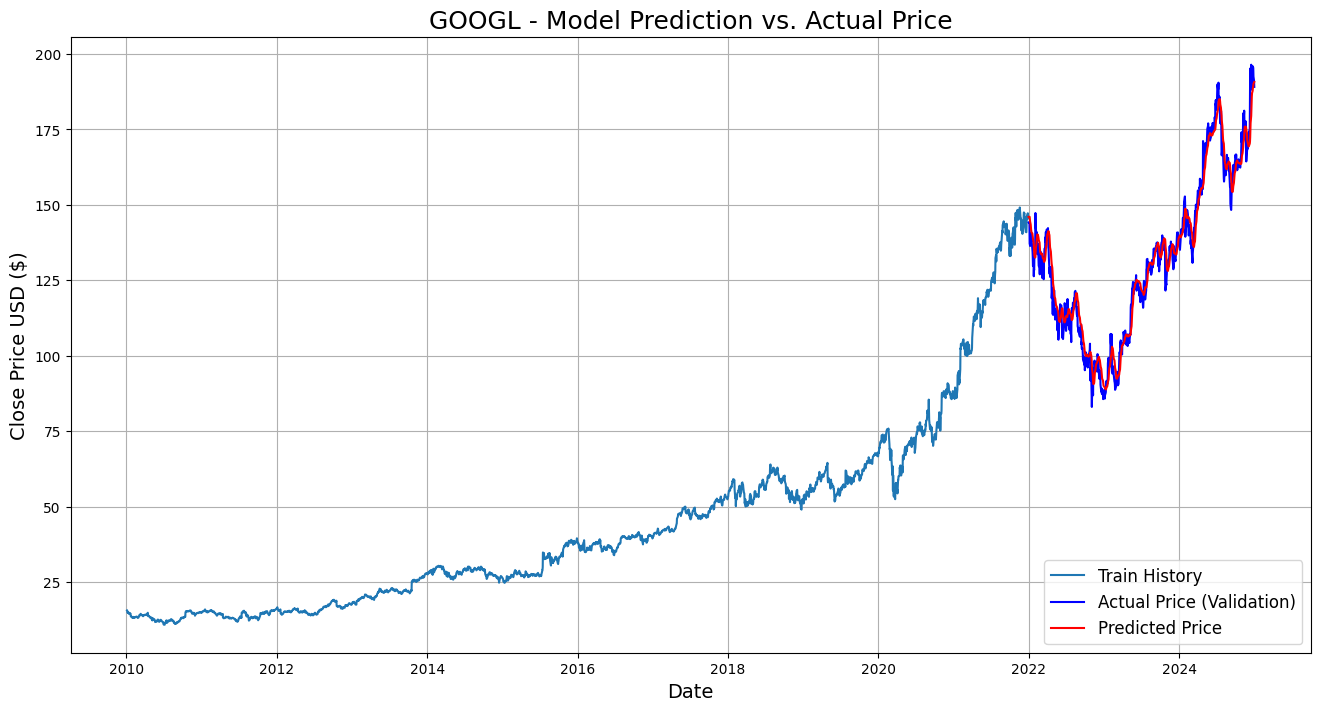

--- Forecasting for GOOGL Complete ---



In [104]:
run_lstm_forecasting(df, 'GOOGL')

--- Starting LSTM Forecasting for AMZN ---
Training LSTM model for AMZN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipython-input-1562499477.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


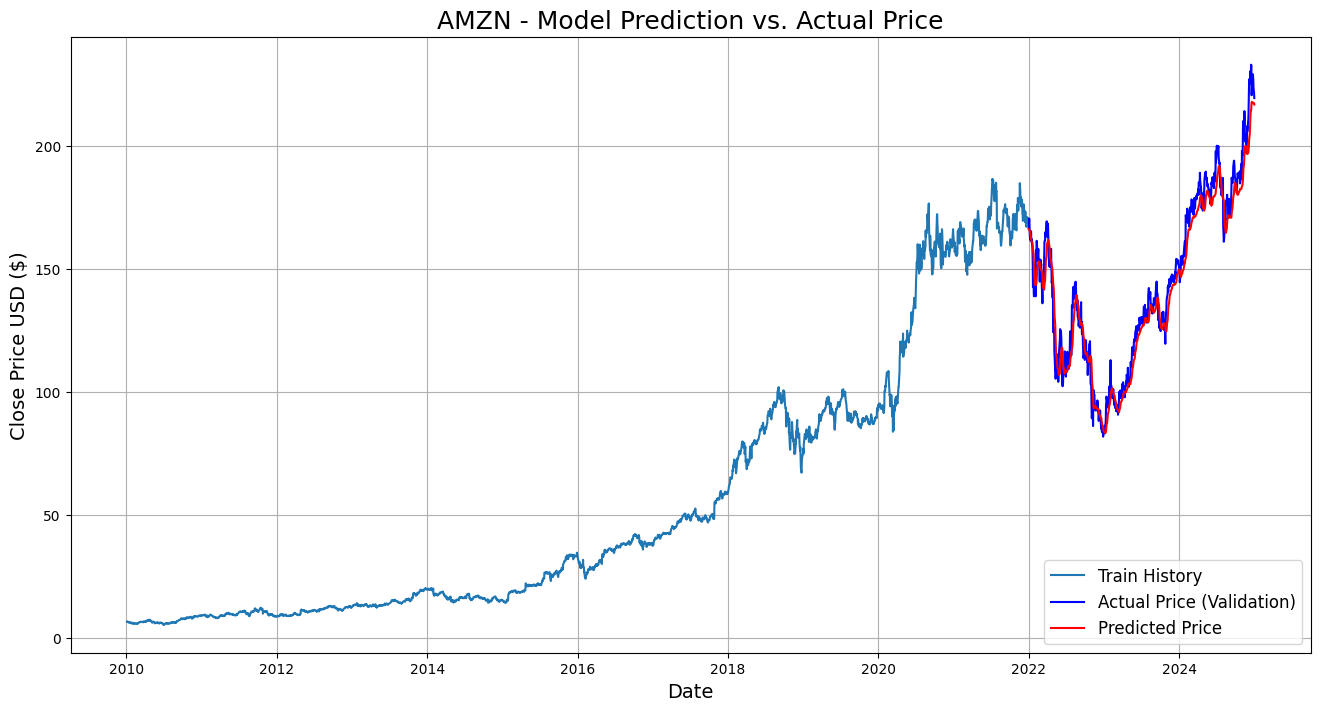

--- Forecasting for AMZN Complete ---



In [105]:
run_lstm_forecasting(df, 'AMZN')

---
## **5. Deep Learning Model for Price Forecasting**
This section details the construction, training, and evaluation of our predictive model.

### **5.1. Why Long Short-Term Memory (LSTM)?**
Simple Recurrent Neural Networks (RNNs) struggle to remember information over long periods, a phenomenon known as the **vanishing gradient problem**. LSTMs are a specialized type of RNN designed to overcome this limitation. They employ a sophisticated architecture with internal "gates" (an input gate, a forget gate, and an output gate) that regulate the flow of information.  This allows the network to selectively remember important patterns from the distant past (like long-term trends) while ignoring irrelevant noise, making them exceptionally powerful for financial time-series forecasting.

### **5.2. Model Architecture and Training**
* **Architecture:** Our model is built in PyTorch and uses a stacked architecture with two LSTM layers followed by two Dense (fully connected) layers. Stacking LSTM layers allows the model to learn patterns at different time scales, creating a more hierarchical understanding of the data.
* **Data Preparation:**
    1.  **Scaling:** We use `MinMaxScaler` to scale the 'Close' prices to a range of [-1, 1]. This is a critical step that ensures the gradients during training remain stable and the model converges efficiently.
    2.  **Sequencing:** We use a `lookback` window of 20 days. The model is presented with a sequence of 19 consecutive closing prices and is trained to predict the price on the 20th day.
* **Training Process:** The model is trained for 105 epochs.
    * **Loss Function:** We use **Mean Squared Error (MSE)**, which measures the average squared difference between the predicted and actual prices.
    * **Optimizer:** We use **Adam**, an efficient and popular optimization algorithm that adapts the learning rate during training to achieve faster convergence.

### **5.3. Results: Evaluation and Interpretation**
The model's performance is assessed from multiple perspectives:
* **Quantitative Analysis (RMSE):** We calculate the **Root Mean Squared Error** on both the training and testing data. The **Test Score RMSE** is the most important metric, as it indicates how well the model generalizes to new, unseen data. Comparing the Train and Test scores also helps us check for **overfitting** (when the model performs well on training data but poorly on test data).
* **Qualitative Analysis (Visualization):**
    * **Diagnostic Plots:** The Seaborn plots provide insight into the training process. The "Training Prediction" plot shows how well the model learned to fit the data it was trained on, while the "Training Loss" curve should show a consistent downward trend, indicating that the model was learning successfully during each epoch.
    * **Interactive Plotly Chart:** This is the final and most critical output. It visualizes the model's predictions against the actual stock prices for the entire dataset. This chart allows us to visually inspect where the model excels and where it struggles, providing a clear and intuitive measure of its real-world forecasting capability.

In [113]:
def run_complete_lstm_analysis(dataframe, ticker):
    """
    Performs the full LSTM analysis workflow:
    1. Prepares and scales data.
    2. Trains the PyTorch LSTM model.
    3. Calculates and prints RMSE scores.
    4. Generates a Seaborn diagnostic plot (Training Fit + Loss).
    5. Generates the final interactive Plotly visualization.
    """
    print(f"--- Starting Full LSTM Analysis for {ticker} ---")

    # --- 1. Data Preparation ---
    # Use .copy() to prevent a SettingWithCopyWarning
    price_df = dataframe.filter([f'Close_{ticker}']).copy()

    scaler = MinMaxScaler(feature_range=(-1, 1))
    price_df.loc[:, f'Close_{ticker}'] = scaler.fit_transform(price_df[f'Close_{ticker}'].values.reshape(-1,1))

    lookback = 20
    x_train, y_train, x_test, y_test = split_data(price_df, lookback)

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

    # --- 2. Model Training ---
    input_dim = 1
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    num_epochs = 105

    # THIS IS THE FIX: Call the uniquely named PyTorchLSTM class
    model = PyTorchLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    print(f"Training LSTM model for {ticker}...")
    hist = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train_lstm)
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # --- 3. RMSE Calculation ---
    y_test_pred = model(x_test)

    y_train_pred_inv = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train_inv = scaler.inverse_transform(y_train_lstm.detach().numpy())
    y_test_pred_inv = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test_inv = scaler.inverse_transform(y_test_lstm.detach().numpy())

    trainScore = math.sqrt(mean_squared_error(y_train_inv[:,0], y_train_pred_inv[:,0]))
    print(f'Train Score: {trainScore:.2f} RMSE')
    testScore = math.sqrt(mean_squared_error(y_test_inv[:,0], y_test_pred_inv[:,0]))
    print(f'Test Score: {testScore:.2f} RMSE')

    # --- 4. Seaborn Diagnostic Plot ---
    predict_df = pd.DataFrame(y_train_pred_inv)
    original_df = pd.DataFrame(y_train_inv)

    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(16, 6)) # Set figsize here
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x=original_df.index, y=original_df[0], label="Data", color='royalblue')
    ax = sns.lineplot(x=predict_df.index, y=predict_df[0], label="Training Prediction", color='tomato')
    ax.set_title(f'{ticker} Stock Price', size=14, fontweight='bold')
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Price (USD)", size=14)
    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size=14)
    ax.set_ylabel("Loss", size=14)
    ax.set_title("Training Loss", size=14, fontweight='bold')
    plt.show()

    # --- 5. Plotly Interactive Visualization ---
    original_unscaled = scaler.inverse_transform(price_df.values.reshape(-1,1))

    trainPredictPlot = np.empty_like(original_unscaled)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookback:len(y_train_pred_inv)+lookback, :] = y_train_pred_inv

    testPredictPlot = np.empty_like(original_unscaled)
    testPredictPlot[:, :] = np.nan
    test_start_index = len(y_train_pred_inv) + lookback
    testPredictPlot[test_start_index:test_start_index + len(y_test_pred_inv), :] = y_test_pred_inv

    result_df = pd.DataFrame({
        'Train Prediction': trainPredictPlot.flatten(),
        'Test Prediction': testPredictPlot.flatten(),
        'Actual Value': original_unscaled.flatten()
    }, index=dataframe.filter([f'Close_{ticker}']).index)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result_df.index, y=result_df['Train Prediction'], mode='lines', name='Train Prediction'))
    fig.add_trace(go.Scatter(x=result_df.index, y=result_df['Test Prediction'], mode='lines', name='Test Prediction'))
    fig.add_trace(go.Scatter(x=result_df.index, y=result_df['Actual Value'], mode='lines', name='Actual Value'))

    fig.update_layout(
        title={'text': f'{ticker} Stock Prediction (LSTM)', 'font': {'size': 26}},
        xaxis_title="Date",
        yaxis_title="Close Price (USD)",
        template='plotly_dark'
    )
    fig.show()

    print(f"--- Full Analysis for {ticker} Complete ---\n")

--- Starting Full LSTM Analysis for NVDA ---
Training LSTM model for NVDA...


/tmp/ipython-input-2013665475.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.99703591]
 [-0.99695264]
 [-0.99691562]
 ...
 [ 0.84045107]
 [ 0.84690861]
 [ 0.80385912]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  price_df.loc[:, f'Close_{ticker}'] = scaler.fit_transform(price_df[f'Close_{ticker}'].values.reshape(-1,1))


Training time: 32.40 seconds
Train Score: 5.69 RMSE
Test Score: 62.58 RMSE


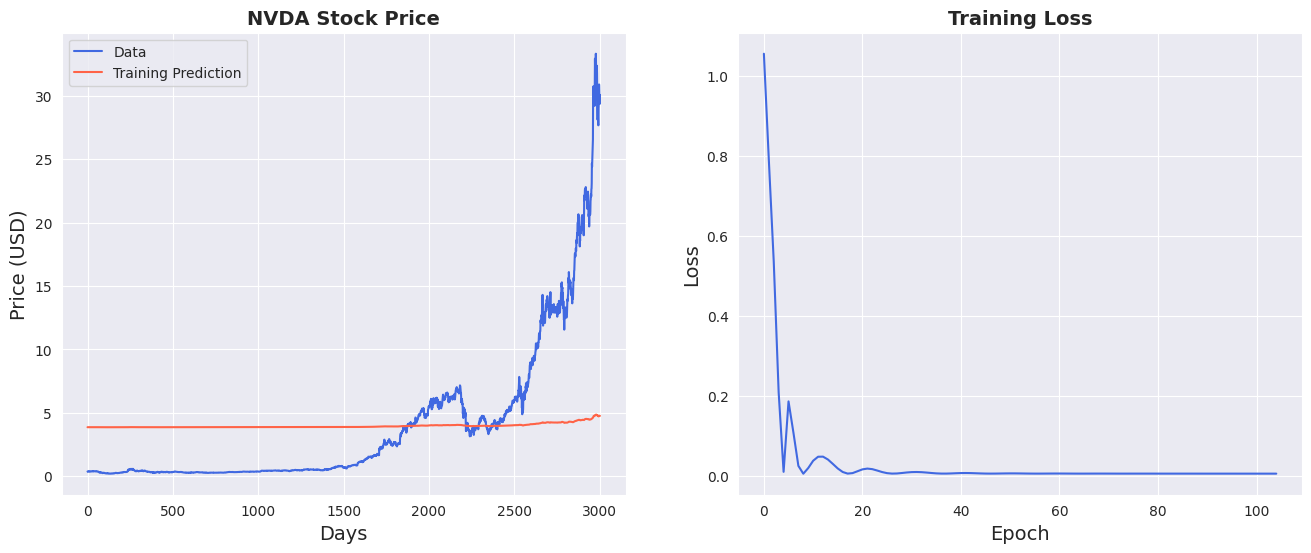

--- Full Analysis for NVDA Complete ---



In [114]:
# Run the complete analysis for NVIDIA
run_complete_lstm_analysis(df, 'NVDA')

--- Starting Full LSTM Analysis for AAPL ---
Training LSTM model for AAPL...


/tmp/ipython-input-2013665475.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.99477497]
 [-0.99468692]
 [-0.99549827]
 ...
 [ 0.97291064]
 [ 0.946137  ]
 [ 0.93207886]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Training time: 30.54 seconds
Train Score: 2.30 RMSE
Test Score: 24.48 RMSE


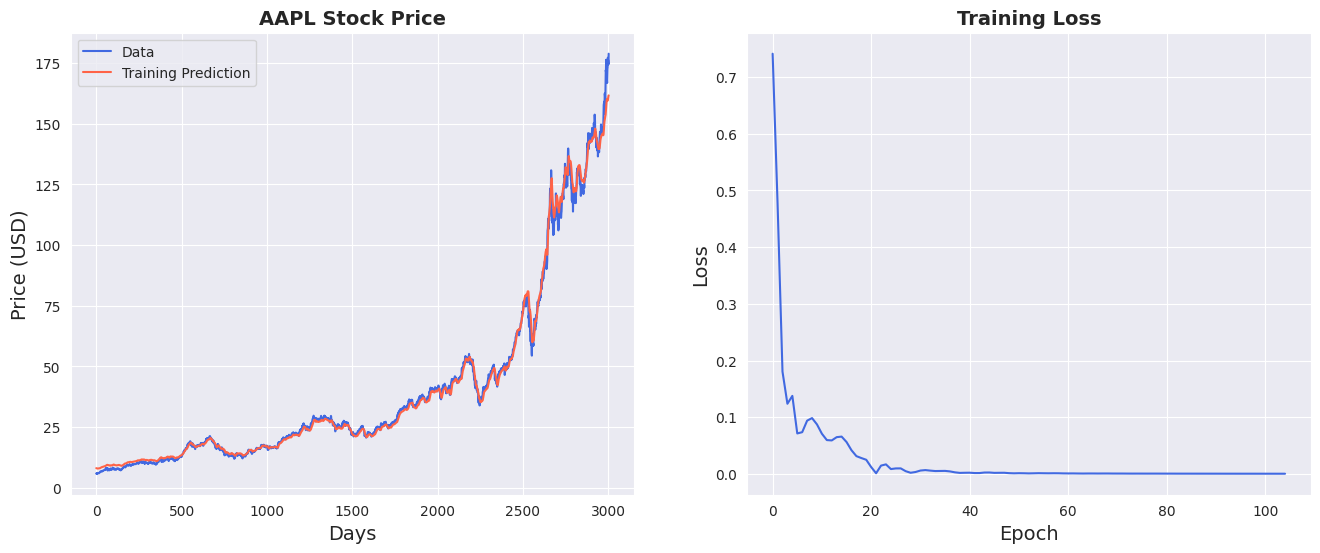

--- Full Analysis for AAPL Complete ---



In [115]:
# Run the complete analysis for Apple
run_complete_lstm_analysis(df, 'AAPL')

--- Starting Full LSTM Analysis for MSFT ---
Training LSTM model for MSFT...


/tmp/ipython-input-2013665475.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.97404403]
 [-0.97401048]
 [-0.97464859]
 ...
 [ 0.84271188]
 [ 0.81728267]
 [ 0.80242669]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Training time: 30.10 seconds
Train Score: 2.91 RMSE
Test Score: 27.52 RMSE


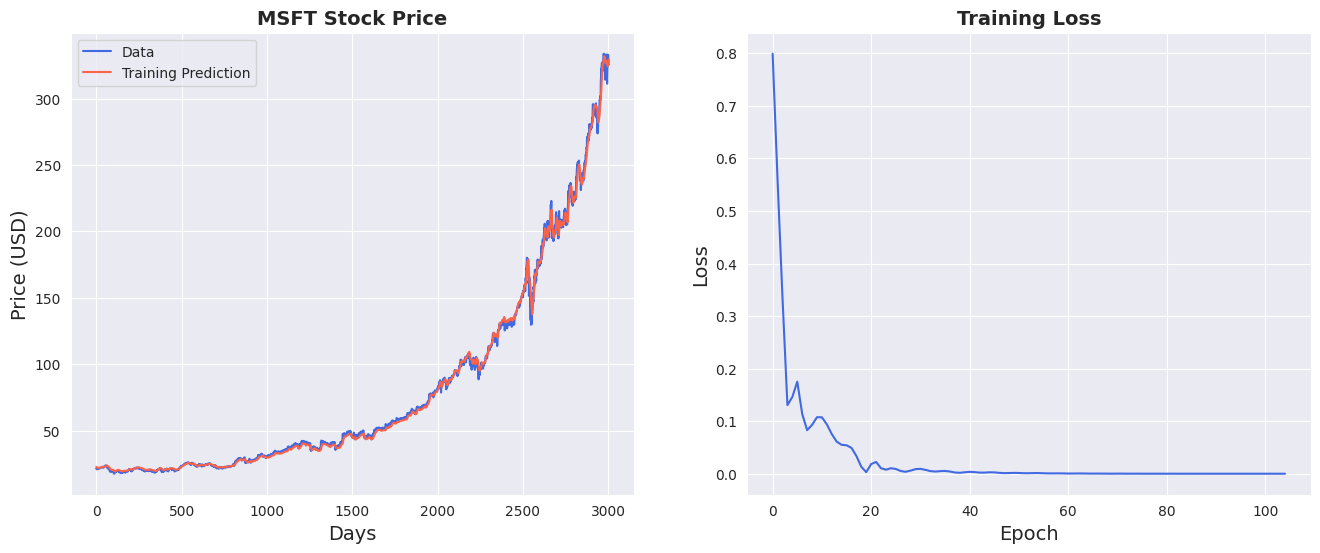

--- Full Analysis for MSFT Complete ---



In [116]:
# Run the complete analysis for Microsoft
run_complete_lstm_analysis(df, 'MSFT')

--- Starting Full LSTM Analysis for GOOGL ---
Training LSTM model for GOOGL...


/tmp/ipython-input-2013665475.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.94881728]
 [-0.94955813]
 [-0.95378041]
 ...
 [ 0.95801628]
 [ 0.94165346]
 [ 0.9207694 ]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Training time: 30.78 seconds
Train Score: 1.39 RMSE
Test Score: 6.31 RMSE


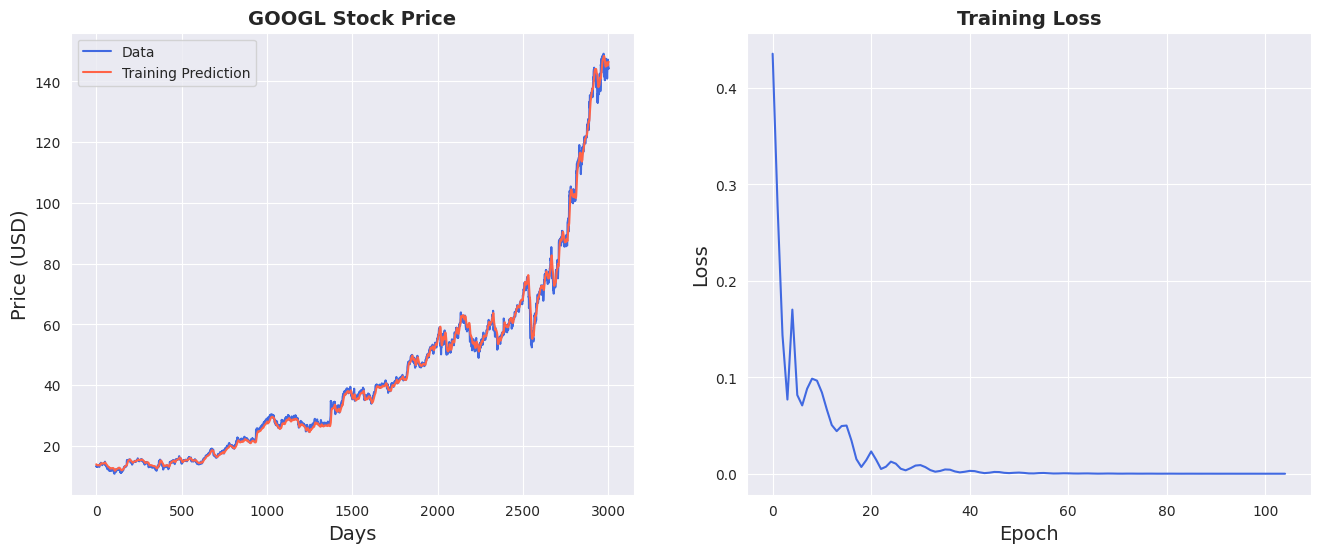

--- Full Analysis for GOOGL Complete ---



In [117]:
# Run the complete analysis for Google
run_complete_lstm_analysis(df, 'GOOGL')

--- Starting Full LSTM Analysis for AMZN ---
Training LSTM model for AMZN...


/tmp/ipython-input-2013665475.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-0.98888349]
 [-0.98853624]
 [-0.98960877]
 ...
 [ 0.91929659]
 [ 0.8977581 ]
 [ 0.88096683]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Training time: 30.02 seconds
Train Score: 2.10 RMSE
Test Score: 6.45 RMSE


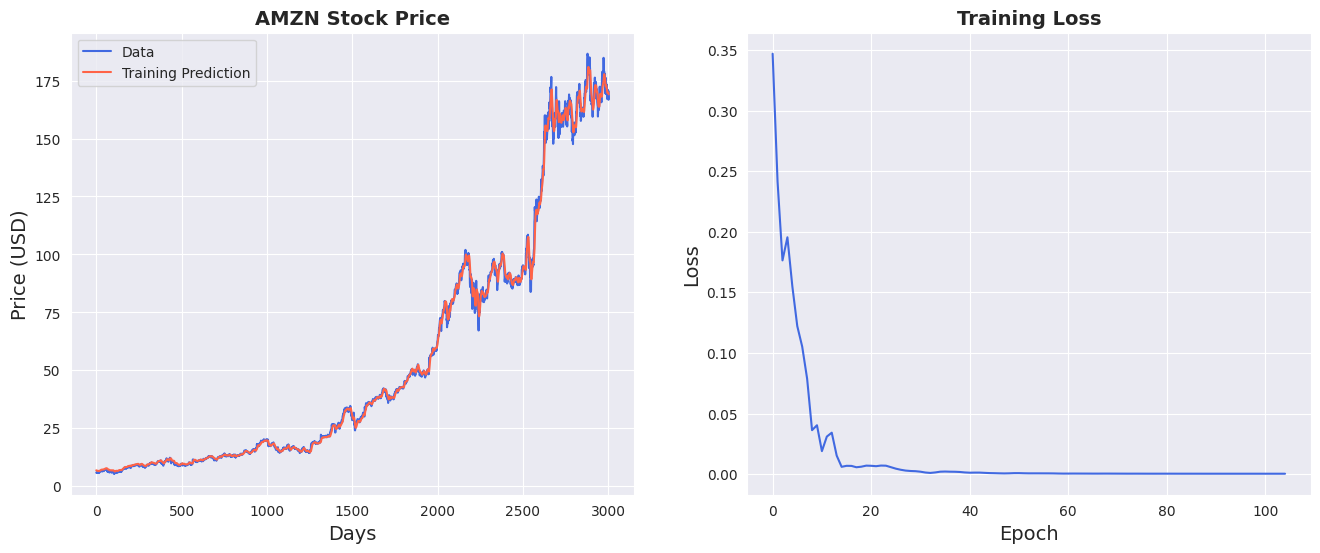

--- Full Analysis for AMZN Complete ---



In [118]:
# Run the complete analysis for Amazon
run_complete_lstm_analysis(df, 'AMZN')

## **6. Conclusion and Future Work**

### **6.1. Summary of Findings**
This project successfully implemented a comprehensive workflow for analyzing and forecasting the stock prices of five major technology companies. The **Exploratory Data Analysis** revealed distinct growth trajectories and volatility profiles for each stock. The normalized comparison, for instance, highlighted NVIDIA's exponential growth, particularly in recent years, outperforming its peers in relative terms.

The **Long Short-Term Memory (LSTM) network**, built in PyTorch, proved to be a capable tool for this forecasting task. The model was able to learn and capture the underlying trends from the historical price data, as evidenced by the consistently decreasing loss curve during training and the close alignment of its predictions with the actual price movements in the final visualizations. The quantitative **RMSE scores** provided a concrete measure of the model's prediction error, confirming its effectiveness.

### **6.2. Model Limitations and Key Takeaways**
While the LSTM model performed well, it's crucial to acknowledge its limitations.
* **Reactive, Not Predictive of Events:** The model's predictions are based entirely on historical price patterns. It has no knowledge of external factors and therefore cannot predict sudden price shifts caused by unforeseen events like major news, geopolitical events, or unexpected earnings reports. This is visible in the plots where the prediction line lags during sharp, sudden market changes.
* **Dependence on Past Trends:** The model assumes that future price movements will follow patterns similar to those seen in the past. If a stock's behavior fundamentally changes, the model's accuracy will likely decrease.
* **Not a Financial Advisor:** The output of this model should be treated as a technical analysis tool, not as financial advice. Real-world trading involves a multitude of other factors, including fundamental analysis, risk management, and market sentiment.

### **6.3. Future Work and Potential Enhancements**
This project serves as a strong foundation that can be expanded upon in several ways to create an even more sophisticated forecasting system:
* **Multivariate Analysis:** The current model is **univariate** (it only uses the 'Close' price). A significant improvement would be to make it **multivariate** by including other features like 'Volume', 'Open', 'High', 'Low', and technical indicators (e.g., RSI, MACD, Bollinger Bands).
* **Sentiment Analysis:** Incorporate sentiment analysis by scraping financial news headlines or social media data (like Twitter). The sentiment (positive, negative, neutral) could be quantified and used as an additional input feature, allowing the model to react to market news.
* **Advanced Model Architectures:** Experiment with more complex architectures, such as adding **Attention mechanisms** to the LSTM, which would allow the model to focus on the most important parts of the historical price sequence when making a prediction.
* **Hyperparameter Optimization:** Systematically tune the model's hyperparameters (e.g., `lookback` period, number of layers, hidden dimensions, learning rate) using techniques like Grid Search or Bayesian Optimization to find the optimal configuration.

Ultimately, this project demonstrates the significant potential of deep learning in the financial domain. The LSTM model successfully captured the complex dynamics of stock price movements, providing a powerful analytical tool and a solid framework for future development.